In [1]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 20)
options(repr.plot.height = 6)

# Regression with Time Lags: Autoregressive Distributed Lag Models

We shall re-do the example from the lecture slides.

Say we have data collected on a monthly basis over five years (i.e., 60 months) on the following variables:

- `Y` market capitalization of Company B ($000)
- `X` the price of oil (dollars per barrel) above the benchmark price

In [2]:
suppressPackageStartupMessages({
  library(readxl)
  library(gdata)
})
txt1 <- "http://uosis.mif.vu.lt/~rlapinskas/(data%20R&GRETL/"
txt2 <- "badnews.xls"
tmp = tempfile(fileext = ".xls")
#Download the file
download.file(url = paste0(txt1, txt2), 
              destfile = tmp, mode = "wb")
#Read it as an excel file
BADNEWS <- read_excel(path = tmp)
BADNEWS <- rename.vars(data.frame(BADNEWS),
                       from = c("Y", "X"),
                       to = c("capit", "price"), info = FALSE)
BADNEWS <- ts(BADNEWS, freq = 12)

Warning message:
"package 'readxl' was built under R version 3.5.2"readxl works best with a newer version of the tibble package.
You currently have tibble v1.4.2.
Falling back to column name repair from tibble <= v1.4.2.
Message displays once per session.


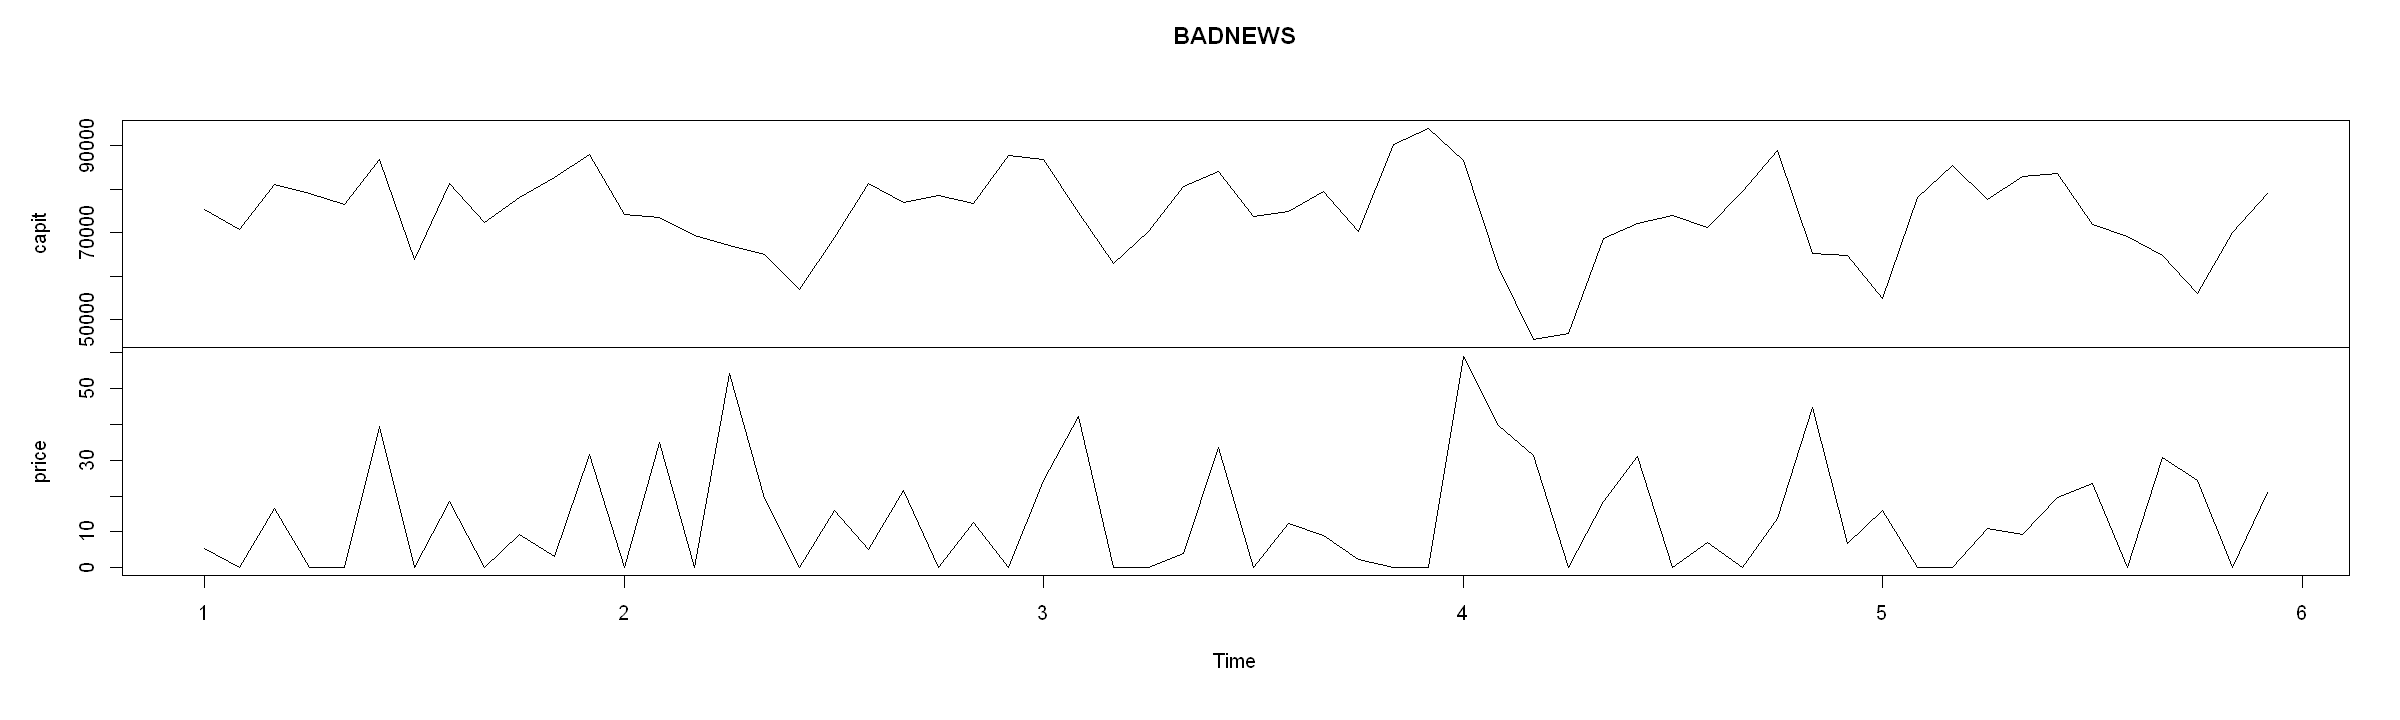

In [3]:
plot.ts(BADNEWS)

Since this is time series data and it is likely that previous months news about the oil price will
affect current market capitalization, it is necessary to include lags of X in the regression.
Below are present OLS estimates of the coefficients in a distributed lag model in which market
capitalization is allowed to depend on present news about the oil price and news up to $q_{max} = 4$ months ago. That is:
$$capit_t = \alpha + \beta_0 price_t + \beta_1 price_{t-1} + ... + \beta_4 price_{t-4} + \epsilon_t$$

In [4]:
suppressPackageStartupMessages({library(dynlm)})
mod.L4 <- dynlm(capit ~ L(price, 0:4), data = BADNEWS)
round(summary(mod.L4)$coef, 4)

Estimate   Std. Error t value Pr(>|t|)
(Intercept)    91173.3150 1949.8502  46.7591 0.0000  
L(price, 0:4)0  -131.9943   47.4361  -2.7826 0.0076  
L(price, 0:4)1  -449.8597   47.5566  -9.4595 0.0000  
L(price, 0:4)2  -422.5183   46.7778  -9.0324 0.0000  
L(price, 0:4)3  -187.1041   47.6409  -3.9274 0.0003  
L(price, 0:4)4   -27.7710   47.6619  -0.5827 0.5627

Just looking at the coefficient values, what can we conclude about the effect of news about the oil price on Company B's market capitalization? 

Increasing the oil price by one dollar per barrel in a given month is associated
with:

1. An immediate reduction in market capitalization of \$ 131'994, _ceteris paribus_.
2. A reduction in market capitalization of \$ 449'860 on month later, _ceteris paribus_.

and so on. To provide some intuition about what the _ceteris paribus_ condition implies in this context, note that, for example, we can also express the second statement as: 'Increasing the oil price by one dollar in a given month will tend to reduce the market capitalization in the following month by \$ 449'860, **assuming that no other change in the oil price occurs**'.

Since the _p-value_ corresponding to the explanatory variable $price_{t-4}$ is **greater** than 0.05, we cannot reject the null hypothesis that $\beta_4 = 0$ at the 5% level of significance. Accordingly we drop this variable from the model and re-estimate the lag length equal to 3, yielding the following results:

In [5]:
mod.L3 <- dynlm(capit ~ L(price, 0:3), data = BADNEWS)
round(summary(mod.L3)$coef, 4)

Estimate   Std. Error t value Pr(>|t|)
(Intercept)    90402.2210 1643.1828  55.0165 0.0000  
L(price, 0:3)0  -125.9000   46.2405  -2.7227 0.0088  
L(price, 0:3)1  -443.4918   45.8816  -9.6660 0.0000  
L(price, 0:3)2  -417.6089   45.7332  -9.1314 0.0000  
L(price, 0:3)3  -179.9043   46.2520  -3.8896 0.0003

The _p-value_ for testing $\beta_3 = 0$ is 0.0003, which is much less than 0.05. We therefore conclude that the variable $price_{t-3}$ does indeed belong in the distributed lag model. Hence $q = 3$ is the lag length we select for this model. 

In a formal report, we would present this table of results or the equation:
$$capit_t = 90402.22 -125.9 price_t -443.49 price_{t-1} -417.61 price_{t-2} -179.90 price_{t-3}$$
Since these results are similar to those discussed above, we will not repeat their interpretation.


# Short-run and Long run multipliers

In general, considering the following model:

$$Y_t = \alpha + \phi Y_{t-1} + \beta_0 X_t + \beta_1 X_{t-1} + \epsilon_t, \quad 0 < \phi < 1$$

- The **short-run multiplier** can be calculated by taking the partial derivatives:
$$\dfrac{\partial Y_t}{\partial X_t} = \beta_0$$
Which shows that an increase in $X$ with one unit has an immediate impact on $Y$ of $\beta_0$ units.

- The **long-run multiplier** (or equilibrium multiplier):

In order to calculate the long-run multiplier, we need to see how a one-unit increase in $X$ at time $t$ affects $Y$ as $t$ increases.

The effect after one period is:
$$\dfrac{\partial Y_{t+1}}{\partial X_t} = \phi \dfrac{\partial Y_t}{\partial X_t} + \beta_1 = \phi \beta_0 + \beta_1$$
Similarly, after two periods:

$$\dfrac{\partial Y_{t+2}}{\partial X_t} = \phi \dfrac{\partial Y_{t+1}}{\partial X_t} = \phi (\phi \beta_0 + \beta_1)$$

and so on. This shows that after the first period, the effect is _decreasing_ **if** $|\phi| < 1$.

Imposing this so-called stability condition (i.e. $|\phi| < 1$) allows us to determine the **long-run** effect of a permenent unit change in $X_t$. 

$$\beta_0 + (\phi \beta_0 + \beta_1) + \phi (\phi \beta_0 + \beta_1) + ... =\beta_0 + (1 + \phi + \phi^2 +...)(\phi\beta_0 + \beta_1) = \dfrac{\beta_0 + \beta_1}{1 - \phi}$$

This says that if the unit increase in $X_t$ is permanent, the expected long-run permanent cumulative change in $Y$ is given by $\dfrac{\beta_0 + \beta_1}{1 - \phi}$.

Note that we can calculate the **symbolic** expressions of the partial derivatives in R! Unfortunately, we cannot combine the expressions in an intuitive way (as we can in `Python`).

We begin by specifying the equations:

In [6]:
expr_t0 = quote(phi*Y.lag.1 + b0*X + b1*X.lag.1)
expr_t1 = substitute(phi * expr_t0 + beta_0 * X_t_plus_1 + beta_1 * X, list(expr_t0 = expr_t0))
expr_t2 = substitute(phi * expr_t1 + beta_0 * X_t_plus_2 + beta_1 * X_t_plus_1, list(expr_t1 = expr_t1))

In [7]:
print("Y_{t}:")
print(expr_t0)
print(paste0(rep("-", 100), collapse= ""))
print("Y_{t+1}:") 
print(expr_t1)
print(paste0(rep("-", 100), collapse= ""))
print("Y_{t+2}:") 
print(expr_t2)
print(paste0(rep("-", 100), collapse= ""))
#print(paste0("Incorrect expression example: ", expression(phi*expr_t0 + b0*X.1 + b1*X)))

[1] "Y_{t}:"
phi * Y.lag.1 + b0 * X + b1 * X.lag.1
[1] "----------------------------------------------------------------------------------------------------"
[1] "Y_{t+1}:"
phi * (phi * Y.lag.1 + b0 * X + b1 * X.lag.1) + beta_0 * X_t_plus_1 + 
    beta_1 * X
[1] "----------------------------------------------------------------------------------------------------"
[1] "Y_{t+2}:"
phi * (phi * (phi * Y.lag.1 + b0 * X + b1 * X.lag.1) + beta_0 * 
    X_t_plus_1 + beta_1 * X) + beta_0 * X_t_plus_2 + beta_1 * 
    X_t_plus_1
[1] "----------------------------------------------------------------------------------------------------"


Then we can calculate the partial derivative expressions:

In [8]:
#Partial derivative of Y_t with respect to X_t
D(expr_t0, "X")
#Partial derivative of Y_{t+1} with respect to X_t
D(expr_t1, "X")
#Partial derivative of Y_{t+2} with respect to X_t
D(expr_t2, "X")

b0

phi * b0 + beta_1

phi * (phi * b0 + beta_1)

We can even evaluate the expression for specific values:

In [9]:
val <- D(expression(phi*Y.lag.1 + b0*X + b1*X.lag.1), "X")
eval(val, envir = list(b0 = 1))
val2 <-  D(expression(phi*(phi*Y.lag.1 + b0*X + b1*X.lag.1) + b0*X.1 + b1*X), "X")
eval(val2, envir = list(b0 = 1, b1 = 0.5, phi = -0.1))

[1] 1

[1] 0.4

# Time Series Regression when Both $Y$ and $X$ are Trend Stationary: Spurious regression

Data contains the yearly data on Puerto Rican employment rate, minimum wage and other variables.

In [10]:
suppressPackageStartupMessages({require(readxl)})
txt1 <- "http://uosis.mif.vu.lt/~rlapinskas/(data%20R&GRETL/"
txt2 <- "prmin.data.xls"
tmp = tempfile(fileext = ".xls")
#Download the file
download.file(url = paste0(txt1, txt2), 
              destfile = tmp, mode = "wb")
#Read it as an excel file
puerto <- ts(read_excel(path = tmp, col_names = FALSE), start=1950, freq = 1)
colnames(puerto)=c("year","avgmin","avgwage","kaitz","avgcov","covt","mfgwage",
                   "prdef","prepop","prepopf","prgnp","prunemp","usgnp","tt","post74",
                   "lprunemp","lprgnp","lusgnp","lkaitz","lprun_1","lprepop","lprep_1",
                   "mincov","lmincov","lavgmin")

Warning message in data.matrix(data):
"NAs introduced by coercion"Warning message in data.matrix(data):
"NAs introduced by coercion"

We will estimate the following model:
$$
\begin{aligned}
lprepop_t &=  \beta_0 + \beta_1 lmincov_t + \beta_2 lusgnp_t + \epsilon_t
\end{aligned}
$$
where

- $lprepop = log(PR employ/popul ratio)$
- $lmincov = log((avgmin/avgwage)*avgcov)$
- $lusgnp = log(US GNP)$

`avgmin` is the average minimum wage, `avgwage` is the average overall wage, and `avgcov` is the average coverage rate (the proportion of workers actually covered by the minimum wage law).

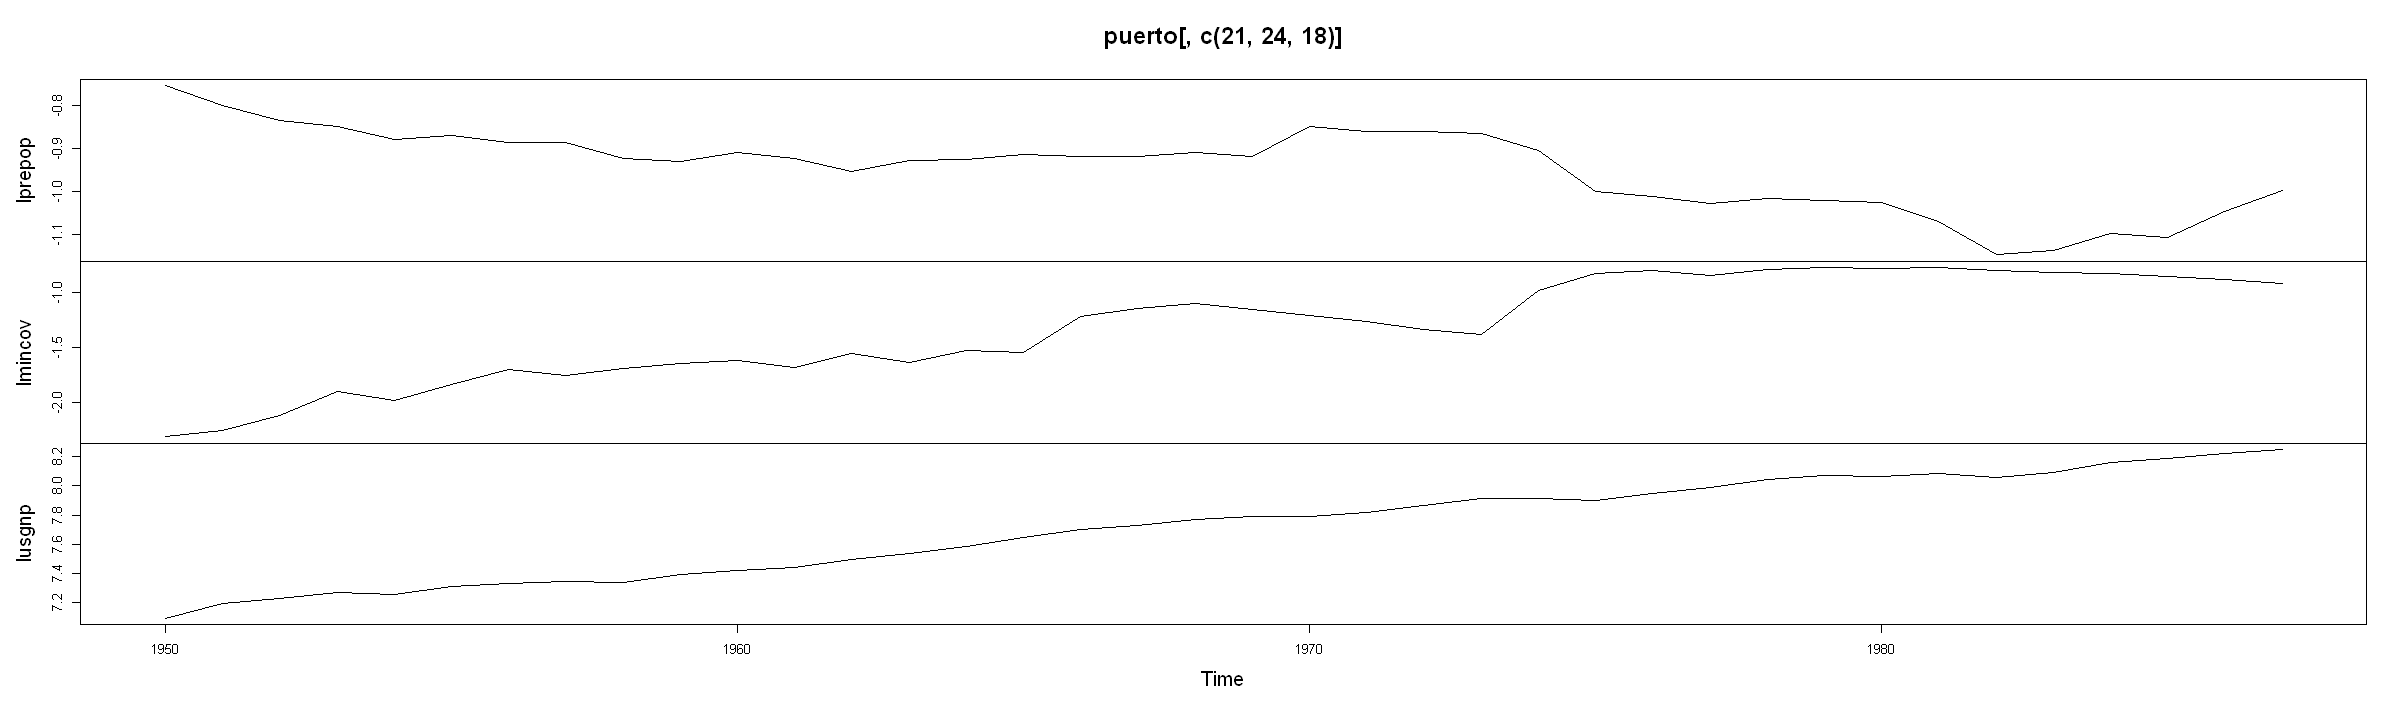

In [11]:
plot(puerto[,c(21,24,18)])


All the variables have a trend close to linear (accurate analysis would require to test for unit root first!).

In [12]:
round(summary(lm(lprepop ~ lmincov + lusgnp, data = puerto))$coefficients, 4)

Estimate Std. Error t value Pr(>|t|)
(Intercept) -1.0544  0.7654     -1.3776 0.1771  
lmincov     -0.1544  0.0649     -2.3797 0.0229  
lusgnp      -0.0122  0.0885     -0.1377 0.8913

Thus, if the minimum wage increases then employment declines which matches classical economics.
On the other hand, the GNP seems to be not significant but we shall test the claim right now:

In [13]:
round(summary(lm(lprepop~lmincov+lusgnp+tt,data=puerto))$coefficients, 4)

Estimate Std. Error t value Pr(>|t|)
(Intercept) -8.6963  1.2958     -6.7113 0e+00   
lmincov     -0.1687  0.0442     -3.8126 6e-04   
lusgnp       1.0573  0.1766      5.9860 0e+00   
tt          -0.0324  0.0050     -6.4415 0e+00

Here, we interpret the coefficient of `lusgnp` as follows: if `usgnp` raises 1% more then, it should according to its long run trend, `prepop` will raise extra 1.057%.

The above regression is equivallent to this (rewritten initial equation in the form of deviations from the trend):

In [14]:
round(
  summary(lm(lm(lprepop~tt)$res~lm(lmincov~tt)$res+lm(lusgnp~tt)$res,data=puerto))$coefficients, 
4)

Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.0000  0.0061      0.0000 1e+00   
lm(lmincov ~ tt)$res -0.1687  0.0436     -3.8683 5e-04   
lm(lusgnp ~ tt)$res   1.0573  0.1741      6.0734 0e+00

In [15]:
# alternatively in a more readable format:
tilde_lprepop <- lm(lprepop~tt, data=puerto)$res
tilde_lmincov <- lm(lmincov~tt, data=puerto)$res
tilde_lusgnp  <- lm(lusgnp~tt, data=puerto)$res
round(
  summary(lm(tilde_lprepop ~ tilde_lmincov + tilde_lusgnp))$coefficients, 
4)

Estimate Std. Error t value Pr(>|t|)
(Intercept)    0.0000  0.0061      0.0000 1e+00   
tilde_lmincov -0.1687  0.0436     -3.8683 5e-04   
tilde_lusgnp   1.0573  0.1741      6.0734 0e+00

We can see that accounting for a time effect determines the significance of the exogenous variables in our model.


# Time Series Regression when Y and X Have Unit Roots: Spurious Regression

Let us analyze daily IBM stock prices spanning May 17, 1961 to November 2, 1962 (369 days in all) and daily closing prices of German DAX index starting at the 130th day of 1991.

Warning message:
"package 'waveslim' was built under R version 3.5.2"

Estimate Std. Error t value Pr(>|t|)
(Intercept) 31.9930  74.0349    0.4321  0.6659  
DAX          0.2735   0.0453    6.0403  0.0000

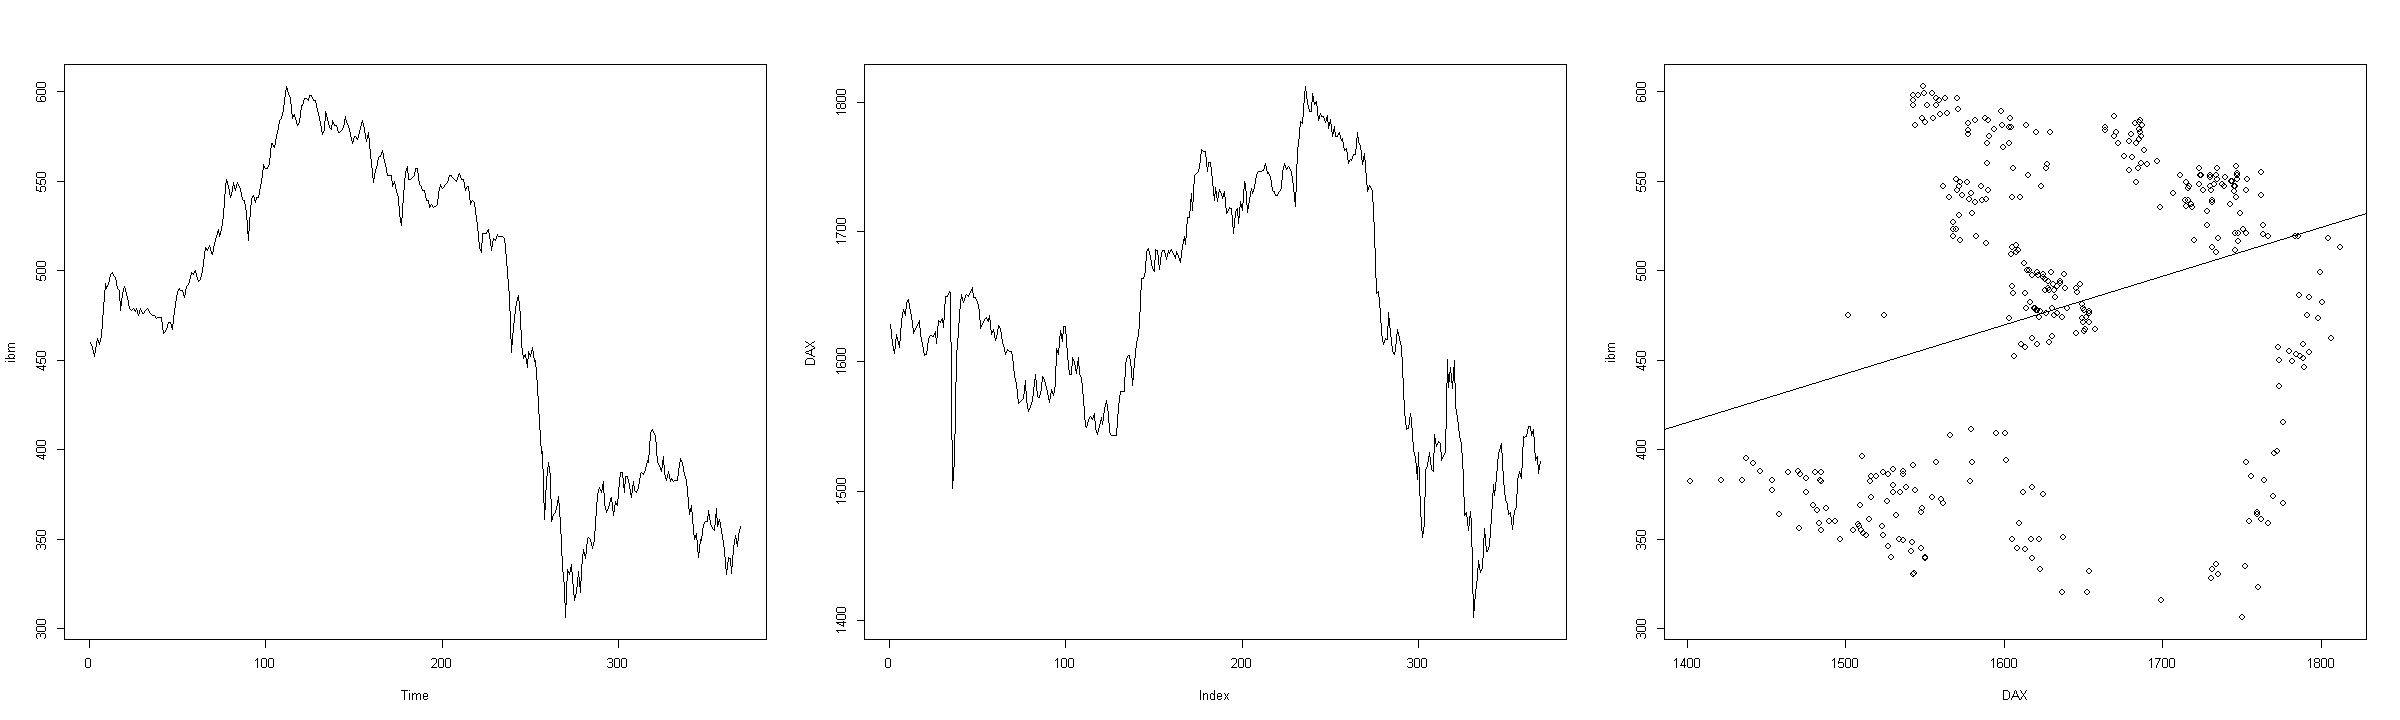

In [16]:
suppressPackageStartupMessages({
  library(dynlm)
  library(waveslim)
  library(datasets)
})
#?ibm
data(ibm)
#?EuStockMarkets
data(EuStockMarkets)
DAX=EuStockMarkets[1:369, 1]
par(mfrow = c(1,3))
plot(ibm); plot(DAX, type = "l")
iD = lm(ibm ~ DAX)
plot(DAX, ibm); abline(iD)
round(summary(iD)$coefficients, 4)

Though, because of their nature, `ibm` and `DAX` should not have any relationship, the coefficient of regression is very significant. This is an example of spurious regression which can be explained through the fact that the errors of the model have a unit root.

The following should be carried out:

1. Establish that `ibm` has a unit root
2. Establish that `DAX` has a unit root
3. Verify that the errors of the `ID` model have a unit root

The (1) and (2) can be carried out in the same manner as in the previous lectures. Regarding (3):

In [17]:
iD.res=ts(iD$res)
round(summary(dynlm(d(iD.res)~L(iD.res)+time(iD.res)))$coefficients, 4)

Estimate Std. Error t value Pr(>|t|)
(Intercept)   1.8987  1.0885      1.7443 0.0820  
L(iD.res)    -0.0134  0.0071     -1.8838 0.0604  
time(iD.res) -0.0113  0.0054     -2.1066 0.0358

Recall that the unit root hypothesis $H_0$ claims that the coefficient at `L(iD.res)` equals zero. In this case of testing for a unit root in errors, we have a further complication: here the t-statistics has not the Dickey-Fuller, but the Engle-Granger distribution whose critical values are given in this table:

| No. of variables <br> (included Y)|<br> 1% | Significance level <br> 5%| <br> 10% |
|:------------------------------------:|:-------:|:--------------------------:|:--------:|
| 2    | -3.90 | -3.34 | -3.04|
| 3    | -4.29 | -3.74 | -3.45|
| 4    | -4.64 | -4.10 | -3.81|
| 5    | -4.96 | -4.42 | -4.13|

In order to test the cointegration of these two variables note that the t-statistics equals -1.884 which is closer to 0 than -3.34, therefore there is no ground to reject $H_0$. Thus the errors have a unit root or, in other words, `ibm` and `DAX` are **not** cointegrated and the strong regression bonds are only spurious.

# Time Series Regression when $Y$ and $X$ Have Unit Roots: Cointegration

It is well known that many economic time series are DS and therefore the regression for levels is often misleading (the standard Student or Wald tests provide wrong p-values). On the other hand, if these DS series are **cointegrated**, the OLS method is OK. 

Recall that if Y and X have unit roots (i.e., are nonstationary), but some linear combination $Y_t - \alpha - \beta X_t$ is (trend) stationary, then we say that Y and X are cointegrated. 

In order to establish cointegration, we estimate unknown coefficients $\alpha$ and $\beta$ by means of OLS and then test whether the **errors** of the model $Y_t = \alpha+ \beta X_t (+ \gamma t) + \epsilon_t$ have a unit root (as always, respective test is applied to the residuals $e_t = \hat{\epsilon}_t = Y_t - \hat{\alpha} - \hat{\beta} X_t (-\hat{\gamma}t)$).

The dataset contains quarterly data, 1947:01 - 1989:03, where

- `lc` - logarithms of the real quarterly personal expenditure (comsumption)
- `ly` - logarithms of the real quarterly aggregated disposable income

In [18]:
txt1 <- "http://uosis.mif.vu.lt/~rlapinskas/(data%20R&GRETL/"
txt2 <- "hamilton.txt"
#Read it as an excel file
ham <- read.csv(paste0(txt1, txt2), header = TRUE, sep = " ")[, -1]
lc=ts(ham[,1],start=1947,freq=4)
ly=ts(ham[,2],start=1947,freq=4)

The cointegration equation:

In [19]:
mod1 = lm(lc ~ ly + time(ly)) # cointegration equation (time included)
round(summary(mod1)$coefficients, 4)

Estimate   Std. Error t value  Pr(>|t|)
(Intercept) -2003.8047 152.3933   -13.1489 0       
ly              0.6557   0.0253    25.9632 0       
time(ly)        1.1410   0.0867    13.1541 0

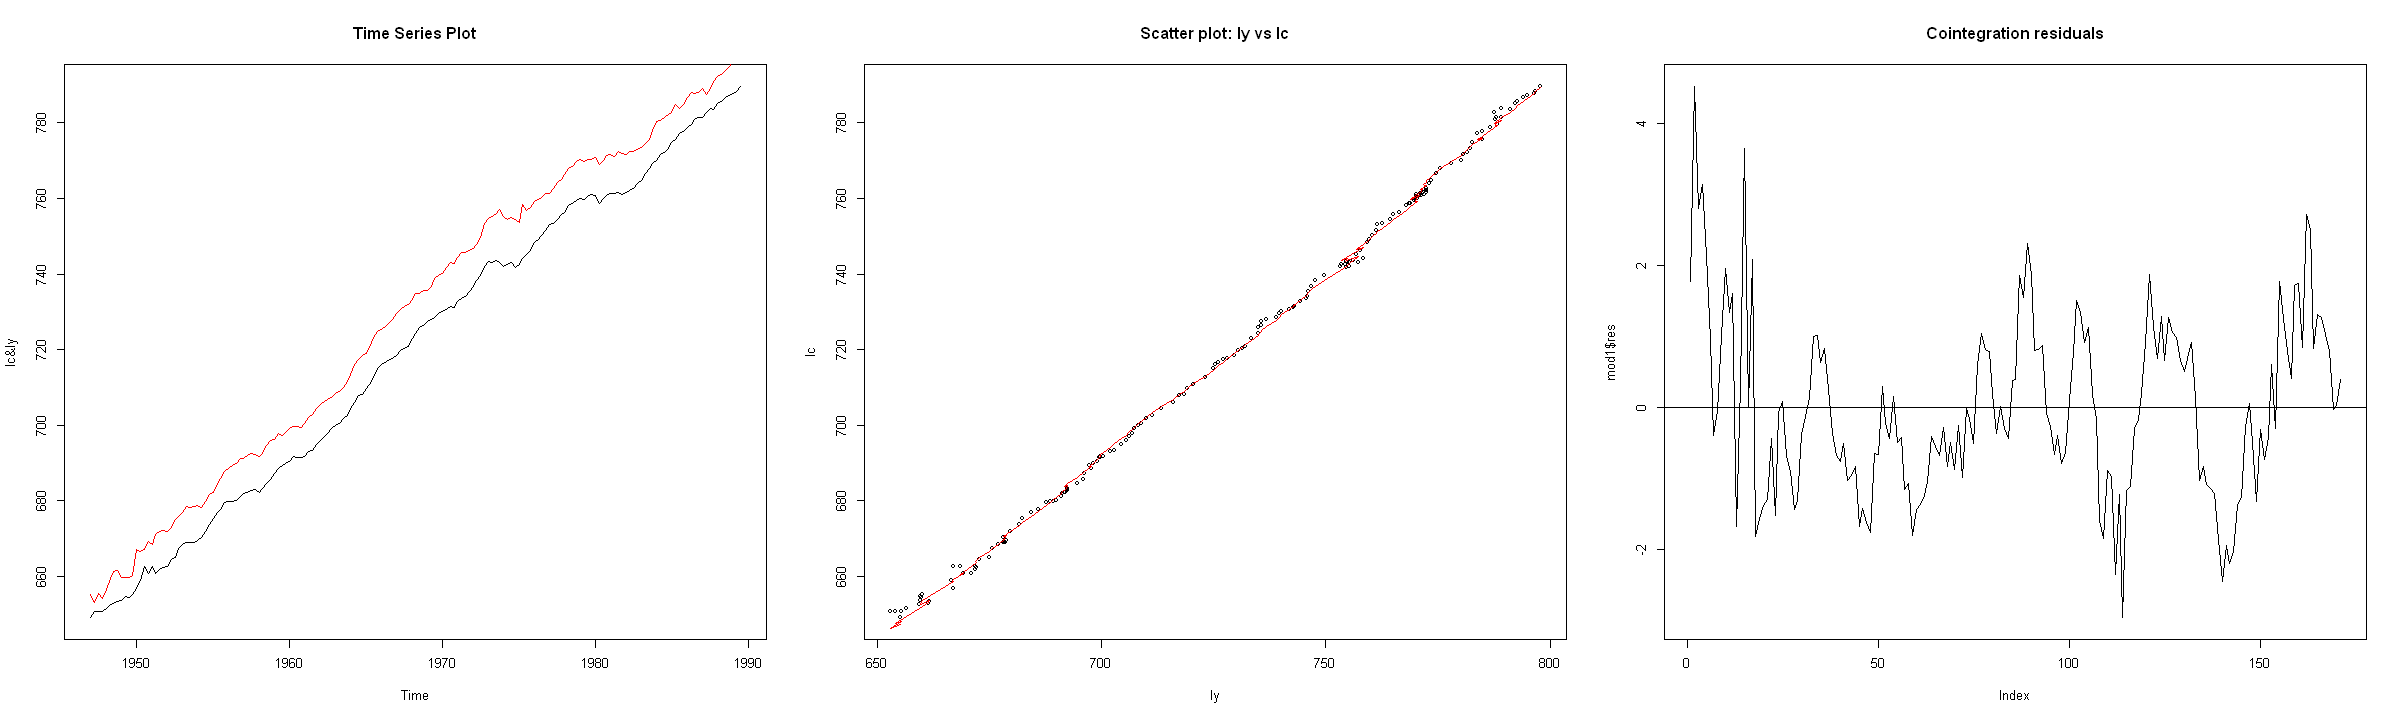

In [20]:
par(mfrow=c(1,3))
plot(lc, ylab = "lc&ly", main = "Time Series Plot")
lines(ly, col=2)
plot(ly, lc, main = "Scatter plot: ly vs lc")
lines(as.numeric(ly),mod1$fit,col = 2)
plot(mod1$res, type = "l", main = "Cointegration residuals");abline(0,0)

It is easy to verify that both series have unit roots and their final models are:

In [21]:
suppressPackageStartupMessages({
  library(dynlm)
  library(urca)
})
#Test for unit root in lc
mod2c = dynlm(d(lc) ~ L(lc) + L(d(lc),1:5) + time(lc))
#Continue the procedure until only the significant variables remain...
mod2c = dynlm(d(lc) ~ L(lc) + L(d(lc), 1:2) + time(lc))

#Do the same for ly
mod4y = dynlm(d(ly) ~ L(ly) + L(d(ly), 1:4))

#Model output
round(summary(mod2c)$coefficients, 4)
round(summary(mod4y)$coefficients, 4)

Estimate  Std. Error t value Pr(>|t|)
(Intercept)    -307.4920 129.8662   -2.3678 0.0191  
L(lc)            -0.0520   0.0218   -2.3918 0.0179  
L(d(lc), 1:2)1    0.0655   0.0759    0.8628 0.3895  
L(d(lc), 1:2)2    0.2395   0.0759    3.1571 0.0019  
time(lc)          0.1755   0.0739    2.3752 0.0187

Estimate Std. Error t value Pr(>|t|)
(Intercept)     2.8023  1.4982      1.8705 0.0632  
L(ly)          -0.0025  0.0020     -1.2216 0.2236  
L(d(ly), 1:4)1  0.0081  0.0764      0.1061 0.9157  
L(d(ly), 1:4)2 -0.0615  0.0753     -0.8163 0.4155  
L(d(ly), 1:4)3  0.0828  0.0753      1.1005 0.2728  
L(d(ly), 1:4)4 -0.2104  0.0737     -2.8558 0.0049

The coeff of `L(lc)` is $-2.392 > -3.45$ and the coeff of `L(ly)` is $-1.222 > -2.89$. In both cases we do not reject the null hypothesis that a unit root is present in each of these time series.

Recall that these models can also be created ´automatically´ (if using `selectlags=´AIC´`) with the `ur.df` function from the urca package:

In [22]:
summary(ur.df(lc, type = "trend", lags = 13,selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0917 -0.3565  0.0356  0.4626  2.7845 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 32.93396   14.24322   2.312  0.02211 * 
z.lag.1     -0.04993    0.02203  -2.266  0.02483 * 
tt           0.04185    0.01869   2.239  0.02658 * 
z.diff.lag1  0.05440    0.07822   0.695  0.48781   
z.diff.lag2  0.25265    0.07819   3.231  0.00151 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7771 on 152 degrees of freedom
Multiple R-squared:  0.08556,	Adjusted R-squared:  0.06149 
F-statistic: 3.555 on 4 and 152 DF,  p-value: 0.008376


Value of test-statistic is: -2.2665 12.4227 2.6088 

Critical values for test statistics: 
      1pct  

Or even easier with the `tseries` pacakge:

In [23]:
tseries::adf.test(lc, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  lc
Dickey-Fuller = -2.0851, Lag order = 5, p-value = 0.5408
alternative hypothesis: stationary


In [24]:
tseries::adf.test(ly, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  ly
Dickey-Fuller = -1.2893, Lag order = 5, p-value = 0.873
alternative hypothesis: stationary


In both cases, `p-value > 0.05`, so we have no grounds to reject the null hypothesis $H_0: \rho = 0$ of a unit root. 

**Having determined that the series is integrated, we want to test whether they are cointegrated.**

We want to test whether the **errors** from the model:

$lc_t = \alpha + \beta ly_t + \gamma t + \epsilon_t$

**make a stationary process**, i.e. the errors do not have a unit root. 

**The arguments of the function `dynlm` must be a `time series`.** We will try two different models cointegration models - one with a trend and one without. We convert the residuals of the cointegrated models to time series objects:

In [25]:
cy.res.no.trend <- ts(lm(lc ~ ly)$res, start = 1947, frequency = 4)
cy.res.trend    <- ts(lm(lc ~ ly + time(lc))$res, start = 1947, frequency = 4)

We want to test whether $|\phi| < 0$ in $cy.res_t = \phi cy.res_{t-1} + \epsilon_t$. However, if the errors of this model do not constitute WN, the standard OLS procedure gives the erroneous estimate of $\phi$. One approach is to replace the AR(1) model by an AR(p) model. Another approach is to use the AR(1) model, but to take into account the fact that the errors are not a WN (this could be done by the Phillips-Ouliaris test).

## 1st method

This method is also called the Engle-Granger method, it tests the unit root in errors hypothesis. However, the OLS procedure proposes the coefficients to the cointegration equation such that the variance of the residuals is minimum, thus the residuals are ¥too stationary´. In other words, the null hypothesis for a unit root will be **rejected too often**.

This is why we use other critical values to test the null hypothesis $H_0: \rho = 0$ and $\Delta e_t = \rho e_{t-1} + \gamma_1 \Delta e_{t-1} + ... + \gamma_{p-1} \Delta e_{t-p+1} + w_t$.

The asymptotic 5% critical values for residual unit root tests for cointegration in 
$$Y_t = \alpha + \beta X_t + \gamma_t + \epsilon_t$$

| No. of X's in the <br> right-hand-side of eq. | No deterministic <br> terms in eq. | Only constant <br> in eq. | Constant and <br> Trend in eq. |
|:----:|:----:|:----:|:----:|
|1| -2.76| -3.37| -3.80|
|2| -3.27| -3.77| -4.16|
|3| -3.74| -4.11| -4.49|
|4| -4.12| -4.45| -4.74|
|5| -4.40| -4.71| -5.03|

we shall perform the test ¡manually´. Here is the final models of residuals:

In [26]:
#Cointegration equation  (without a trend)
round(
  summary(dynlm(d(cy.res.no.trend)~-1+L(cy.res.no.trend)+L(d(cy.res.no.trend),1:4)))$coefficients,
4)

Estimate Std. Error t value Pr(>|t|)
L(cy.res.no.trend)          -0.1450  0.0527     -2.7520 0.0066  
L(d(cy.res.no.trend), 1:4)1 -0.2725  0.0798     -3.4143 0.0008  
L(d(cy.res.no.trend), 1:4)2 -0.0806  0.0817     -0.9868 0.3252  
L(d(cy.res.no.trend), 1:4)3 -0.0378  0.0808     -0.4678 0.6406  
L(d(cy.res.no.trend), 1:4)4 -0.2296  0.0732     -3.1377 0.0020

In this case, we have that since -2.752 is closer to zero than -3.37, we do not reject the unit root in errors null hypothesis, thus the processes `lc` and `ly` are **not cointegrated**.

In [27]:
#Cointegration equation (with a trend)
round(
  summary(dynlm(d(cy.res.trend)~-1+L(cy.res.trend)+L(d(cy.res.trend),1)))$coefficients,
4)

Estimate Std. Error t value Pr(>|t|)
L(cy.res.trend)       -0.2415  0.0532     -4.5368 0.0000  
L(d(cy.res.trend), 1) -0.2208  0.0716     -3.0845 0.0024

On the other hand, if we include a trend component, then our t-statistic -4.5368 < -3.80. In this case, we **reject** the null hypothesis, i.e. we would get that `lc` and `ly` are cointegrated!.

This highlights one drawback of the Engle-Granger procedure - Engle-Granger test does not consistently indicate cointegration. One possible explanation is that the Engle-Granger and Dickey-Fuller tests are known to have low power. 

## 2nd method

The **Phillips-Ouliaris cointegration test** of 
$$H_0: \text{x and y are not cointegrated}$$
can be performed with the `ca.po` function from the `urca` package or `po.test` from `tseries` package:

In [28]:
#Digit display options
options("scipen" = 0)

In [29]:
cy.data=cbind(lc,ly)
cy.po <- urca::ca.po(cy.data, demean = "trend", type="Pz")
summary(cy.po)


######################################## 
# Phillips and Ouliaris Unit Root Test # 
######################################## 

Test of type Pz 
detrending of series with constant and linear trend 

Response lc :

Call:
lm(formula = lc ~ zr + trd)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.85014 -0.37853 -0.00368  0.50769  3.08677 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 33.85240   14.79603   2.288   0.0234 *  
zrlc         0.88800    0.04841  18.345   <2e-16 ***
zrly         0.06024    0.03552   1.696   0.0918 .  
trd          0.04291    0.01940   2.212   0.0283 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7874 on 166 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9996 
F-statistic: 1.582e+05 on 3 and 166 DF,  p-value: < 2.2e-16


Response ly :

Call:
lm(formula = ly ~ zr + trd)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4872 -0.4648  0.0

The test statistics 49.341 is closer to 0 than 81.3812 (alternatively, since 49.341 < 81.3812), therefore we **do not reject** the null hypothesis and conclude that `lc` and `ly` are **not cointegrated**.

---

Note that according to [this stackexchange question](https://stats.stackexchange.com/questions/14615/did-i-find-a-bug-in-the-tseries-or-urca-packages) you may get conflicting results from `tseries::po.test`. Indeed:

In [30]:
tseries::po.test(x = cy.data, demean = TRUE, lshort = TRUE)

Warning message in tseries::po.test(x = cy.data, demean = TRUE, lshort = TRUE):
"p-value smaller than printed p-value"


	Phillips-Ouliaris Cointegration Test

data:  cy.data
Phillips-Ouliaris demeaned = -29.975, Truncation lag parameter = 1,
p-value = 0.01


At first glance it would seem that we get conflicting results.


More details can be found [here](https://statcompute.wordpress.com/2018/12/16/phillips-ouliaris-test-for-cointegration/). The takeaway is:

> After reading through the original paper “Asymptotic Properties of Residual Based Tests for Co-Integration” by P. Phillips again, I started realizing that the po.test() function in the tseries package and the ca.po() function in the urca package are implementing different types of Phillips-Ouliaris cointegration tests. In other words, the so-called “Phillips-Ouliaris Cointegration test” is not A statistical test but a set of statistical tests with different assumptions, formulations, critical values, and implications. 

and

> At last, let’s look at the Pz test implemented in the ca.po() function. For this test, critical values in tables IVa – IVc in P192 are used to reject the Null of No Cointegration. As a multivariate trace statistic, the Pz test has its appeal that the outcome won’t change by the position of each series, as shown below.

`urca::ca.po(cbind(x, y, z), demean = "constant", lag = "short", type = "Pz")`

`# The value of the test statistic is: 219.2746`

`urca::ca.po(cbind(z, x, y), demean = "constant", lag = "short", type = "Pz")`

`# The value of the test statistic is: 219.2746 `

# Time Series Regression when Y and X are Cointegrated: the Error Correction Model

If $X$ and $Y$ are integrated but not cointegrated, their ties (in levels) can only be spurious. In order
to get sensible results, the model may be augmented with new variables or another ADL model for
(stationary differences) created:
$$\Delta Y_t = \phi + \gamma_1 \Delta Y_{t-1} + ... + \gamma_p \Delta Y_{t-p} + \omega_0 \Delta X_t + ... + \omega_q \Delta X_{t-q} + \epsilon_t$$

Similar model can also be analyzed in the case of cointegration, but then one more term, the so-called error correction term $\hat{u}_{t-1}$ (here $Y_t = \alpha + \beta X_t + u_t$ is a long-run equilibrium or cointegration equation) should be included:
$$\Delta Y_t = \phi + \delta t + \lambda \hat{u}_{t-1} + \gamma_1 \Delta Y_{t-1} + ... + \gamma_p \Delta Y_{t-p} + \omega_0 \Delta X_t + ... + \omega_q \Delta X_{t-q} + \epsilon_t$$

***This is the error correction model (ECM)*** where the coefficient $\lambda$ must be negative (e.g., if $\lambda = -0.25$, then unit deviation from equilibrium will be compensated in $1/0.25=4$ time units).

The ECM is usually created in two steps:

1. Estimate the long-run equilibrium model: $Y_t = \alpha + \beta X_t + u_t$ and save its residuals;
2. Estimate the regression model:

$$\Delta Y_t = \phi + \delta t + \lambda \hat{u}_{t-1} + \gamma_1 \Delta Y_{t-1} + ... + \gamma_p \Delta Y_{t-p} + \omega_0 \Delta X_t + ... + \omega_q \Delta X_{t-q} + \epsilon_t$$

**Let us say, that we found that `lnQ` and `ln(X/G)` are cointegrated** (this should be tested as a separate step!) from the dataset, where:

- NF = expenditure on food in current prices
- RF = expenditure on food in constant prices = Q demand for food
- NTE = total expenditure in curent prices = X total expenditure
- RTE = total expenditure in constant prices

In [31]:
txt1 <- "http://uosis.mif.vu.lt/~rlapinskas/(data%20R&GRETL/"
txt2 <- "data1.txt"
#Read it as an excel file
d1 <- ts(read.table(paste0(txt1, txt2), header = TRUE), start=1963)
X=d1[,"NTE"]
Q=d1[,"RF"]
P=d1[,"NF"]/d1[,"RF"]
G=d1[,"NTE"]/d1[,"RTE"]

We begin by estimating the long-run equilibrium model:

In [32]:
c1=lm(log(Q)~log(X/G))
summary(c1) # cointegration (equilibrium) equation


Call:
lm(formula = log(Q) ~ log(X/G))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.060861 -0.013353 -0.006115  0.015492  0.047468 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.11378    0.25406   28.00   <2e-16 ***
log(X/G)     0.35537    0.01778   19.99   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02478 on 28 degrees of freedom
Multiple R-squared:  0.9345,	Adjusted R-squared:  0.9322 
F-statistic: 399.5 on 1 and 28 DF,  p-value: < 2.2e-16


In [33]:
c1res = ts(c1$res,start=1963)

We use the residuals of the cointegration equation c1 and create a regression model:
$$\Delta lnQ_t = \lambda \cdot clres_{t-1} + \gamma_1 \Delta lnQ_{t-1} + \omega_0 \Delta ln(X/G)_t + \omega_1 \Delta ln(X/G)_{t-1} + \epsilon_t$$

In [34]:
mod1 = dynlm(d(log(Q))~ -1 + L(c1res) + L(d(log(Q))) + L(d(log(X/G)),0:1))
summary(mod1)


Time series regression with "ts" data:
Start = 1965, End = 1992

Call:
dynlm(formula = d(log(Q)) ~ -1 + L(c1res) + L(d(log(Q))) + L(d(log(X/G)), 
    0:1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.023810 -0.007176 -0.001476  0.006199  0.028039 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
L(c1res)              -0.4233     0.1208  -3.504 0.001823 ** 
L(d(log(Q)))           0.4051     0.1592   2.545 0.017794 *  
L(d(log(X/G)), 0:1)0   0.5368     0.1347   3.984 0.000548 ***
L(d(log(X/G)), 0:1)1  -0.2532     0.1387  -1.825 0.080523 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01307 on 24 degrees of freedom
Multiple R-squared:  0.7338,	Adjusted R-squared:  0.6894 
F-statistic: 16.54 on 4 and 24 DF,  p-value: 1.242e-06


The error correction term has the right sign and is significant (coef. of `L(c1res)` has a `p-value = 0.001823 < 0.05`), the model itself is quite acceptable.

We can still improve the model by including other differences of $I(1)$ variables, eg.s. log-differences of relative food prices P/G:
$$\Delta lnQ_t = \lambda \cdot clres_{t-1} + \gamma_1 \Delta lnQ_{t-1} + \omega_0 \Delta ln(X/G)_{t} + \omega_1 \Delta ln(X/G)_{t-1} + \tilde{\omega}_0 \Delta ln(P/G)_{t-1} + \tilde{\omega}_1 \Delta ln(P/G)_t+ \epsilon_t$$
After deleting insignificant terms, we get such an ECM:

In [35]:
mod2 = dynlm(d(log(Q))~-1+L(c1res)+L(d(log(Q)))+d(log(X/G))+d(log(P/G)))
summary(mod2)


Time series regression with "ts" data:
Start = 1965, End = 1992

Call:
dynlm(formula = d(log(Q)) ~ -1 + L(c1res) + L(d(log(Q))) + d(log(X/G)) + 
    d(log(P/G)))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.017798 -0.011171 -0.002318  0.005203  0.027164 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
L(c1res)     -0.40437    0.10795  -3.746 0.000999 ***
L(d(log(Q)))  0.24010    0.13413   1.790 0.086080 .  
d(log(X/G))   0.36579    0.08985   4.071 0.000440 ***
d(log(P/G))  -0.32361    0.10135  -3.193 0.003906 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01169 on 24 degrees of freedom
Multiple R-squared:  0.7872,	Adjusted R-squared:  0.7518 
F-statistic:  22.2 on 4 and 24 DF,  p-value: 8.984e-08


- Here the short-run demand elasticities with respect to total real expenditure and relative price are `0.36579` and `0.32361`, respectively. 
- In the **long-run**, however, demand is independent of relative price, while the expenditure elasticity falls sligthly to the `0.35537` in the equilibrium relationship (see the model `c1` above).

We also note, that the residuals are WN:

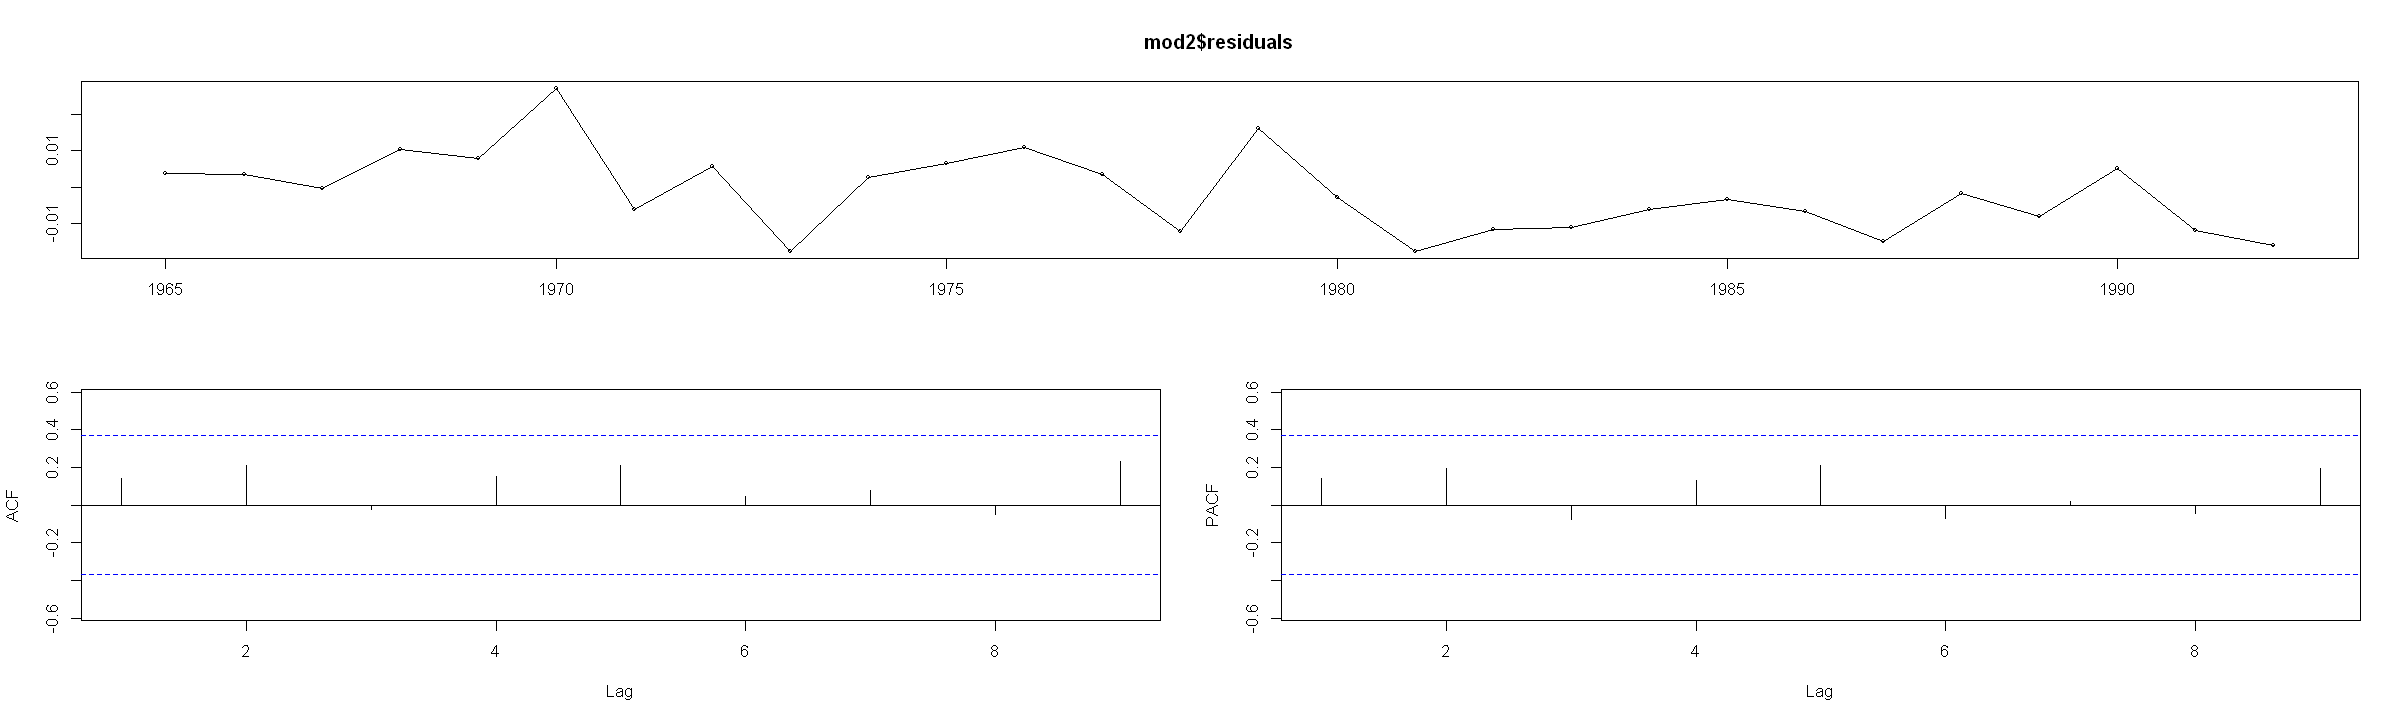

In [36]:
suppressPackageStartupMessages({library(forecast)})
tsdisplay(mod2$residuals)

---
---
---

Another note on the long-run equilibrium relationship. Assume that $X_y , X_t \sim I(1)$ and $X_t$ and $Y_t$ are cointegrated.

Assume that the long-run relationship can be defiend as:
$$
Y_t = \alpha + \beta X_t + \epsilon_t
$$

In practical applications we are dealing with **finite samples**, hence the long-run multiplier parameter is difficult to estimate from this equation. Furthermore, ignoring the **short-run dynamics** would lead to biased estimates in **small** samples.


However, if we look at the short-run relationship, which is described by an ADL model:
$$
Y_t = \alpha + \delta t + \sum_{i = 1}^p \phi_i Y_{t-i} + \sum_{j = 0}^q \beta_j X_{t-j} + \epsilon_t
$$
we can re-write it in terms of differences:
$$
\Delta Y_t = \alpha + \delta t + \rho Y_t + \sum_{i = 1}^{p-1} \gamma_i \Delta Y_{t-1} + \theta X_t + \sum_{j = 1}^{q-1} \Delta X_{t-j} + \epsilon_t
$$

**Examine the lecture slides and familiarize with how this relationship is derived**. From the lecture slides we know that the relationship between this equations parameters and the long-run multiplier is:
$$
\beta = - \dfrac{\theta}{\rho}
$$
which we can estimate from our finite sample.

-----

## Dynamic Regression Example with US data

According to the [Phillips curve](https://en.wikipedia.org/wiki/Phillips_curve) - if unemployment is above its equilibrium (i.e. the *natural* rate of unemployment), then the rate of inflation will increase.

The **short-run Phillips curve** is also called the **expectations-augmented Phillips curve**, since it shifts up when inflationary expectations rise. In the long run, this implies that **monetary policy cannot affect unemployment**, which adjusts back to its "natural rate", also called the **NAIRU** (long-run Phillips curve). 

However, this long-run *neutrality* of monetary policy does allow for **short run fluctuations** and the ability of the monetary authority to **temporarily** decrease unemployment by increasing **PERMANENT** inflation, and vice versa.

For some theoretical background, see [here](https://www.khanacademy.org/economics-finance-domain/ap-macroeconomics/ap-long-run-consequences-of-stabilization-policies/the-phillips-curve/a/the-phillips-curve)

So, we want to examine how changes in `unemployment` affect `inflation`. 

In [37]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 20)
options(repr.plot.height = 8)

# 1. Plot the data series and examine their stationarity

In [38]:
data(USMacroG, package = "AER")

In [39]:
head(USMacroG[, c("unemp", "inflation")])

unemp inflation
[1,] 6.4        NA  
[2,] 5.6    4.5071  
[3,] 4.6    9.9590  
[4,] 4.2    9.1834  
[5,] 3.5   12.6160  
[6,] 3.1    1.5494

Since the first row does not have a value for `inflation`, we will remove it (this will avoid any errors when testing the series). We will also drop the first few more observations, as they seem to be larger shift, which may need some other model specification, or more variables to explain.

In [40]:
USMacroG <- tail(USMacroG, -6) # equivalent to USMacroG[-c(1:6), ], but this PRESERVES the ts() format

Now we can examine the data:

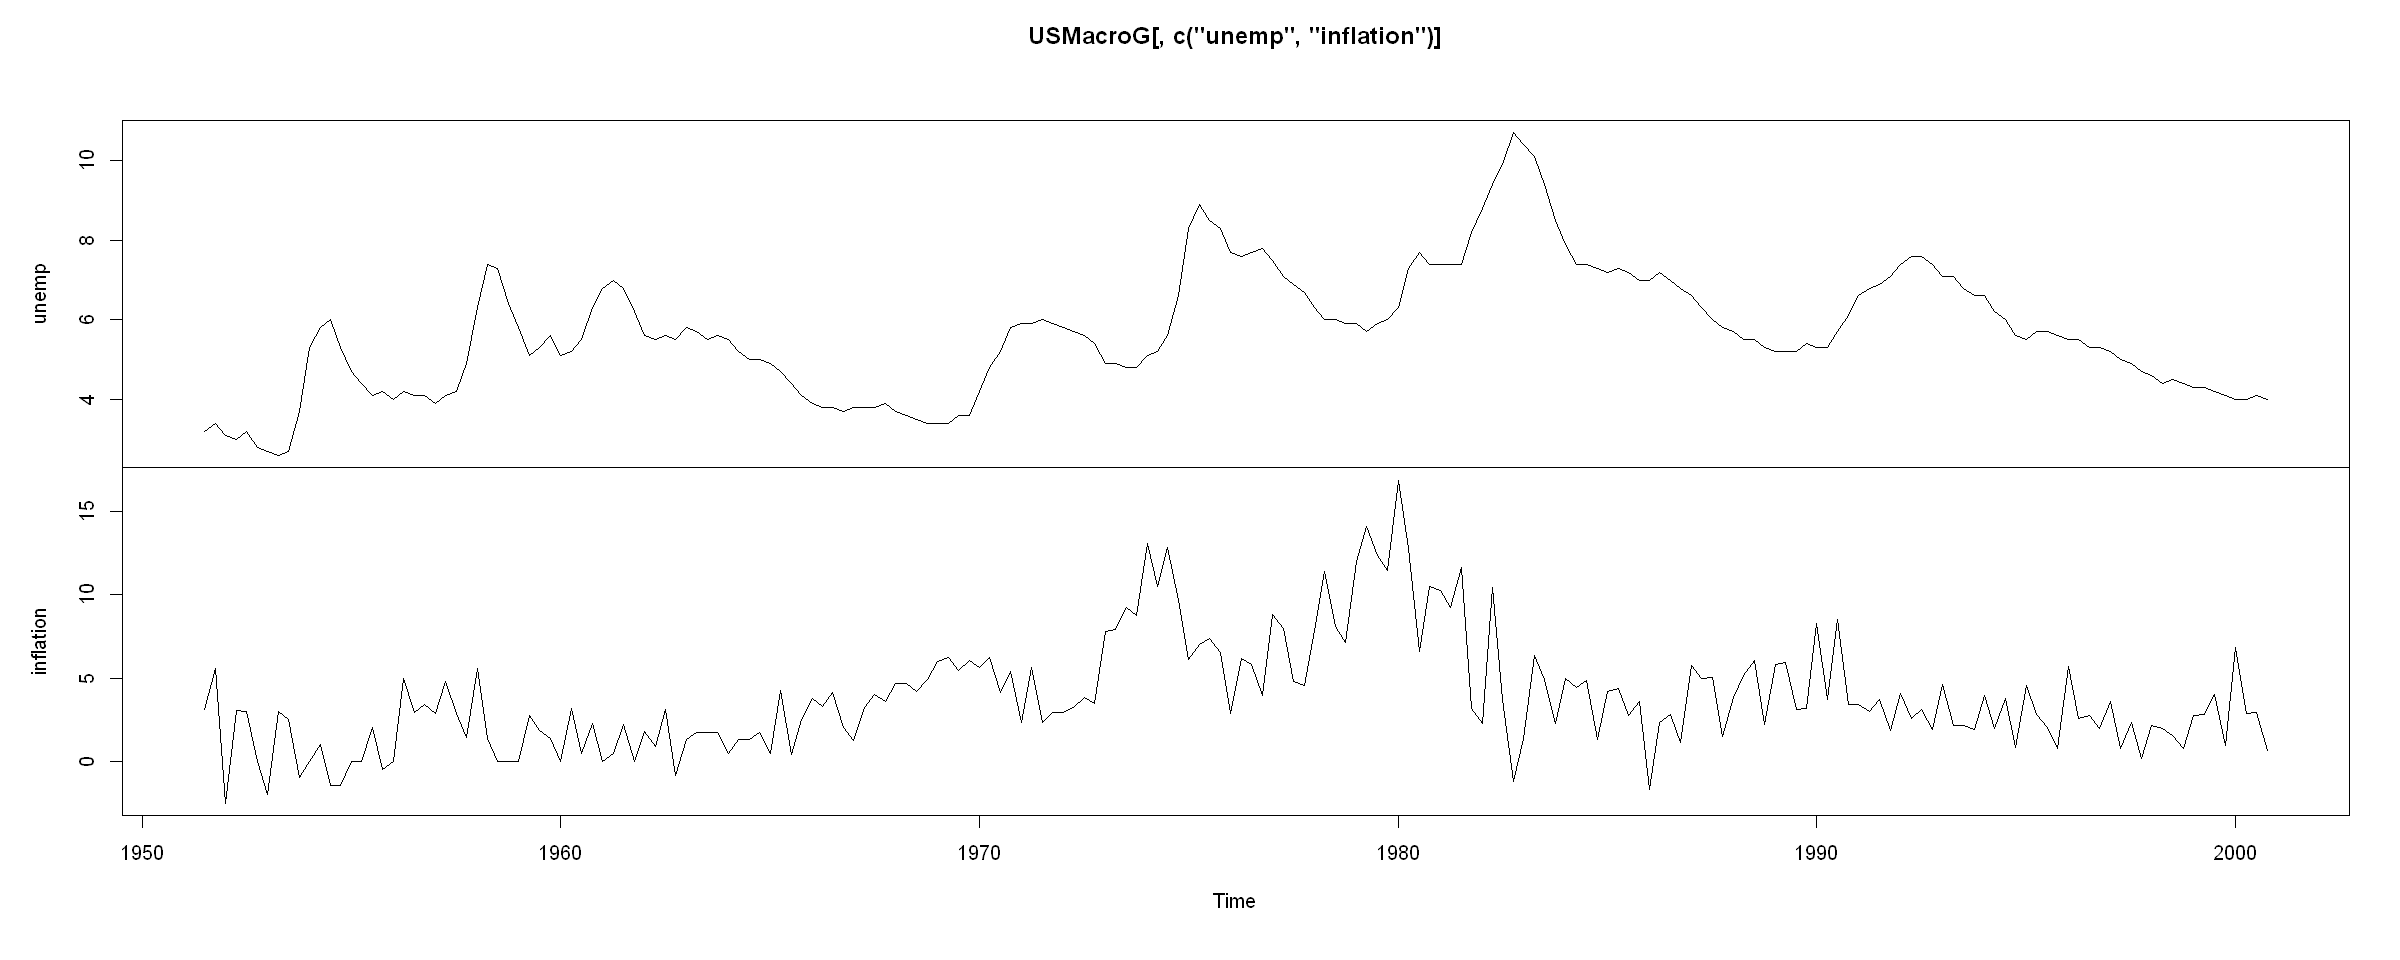

In [41]:
plot(USMacroG[, c("unemp", "inflation")])

The series do not appear to have an exponential growth.

# 2. Plot the ACF/PACF of the series - do they appear to be autocorrelated?

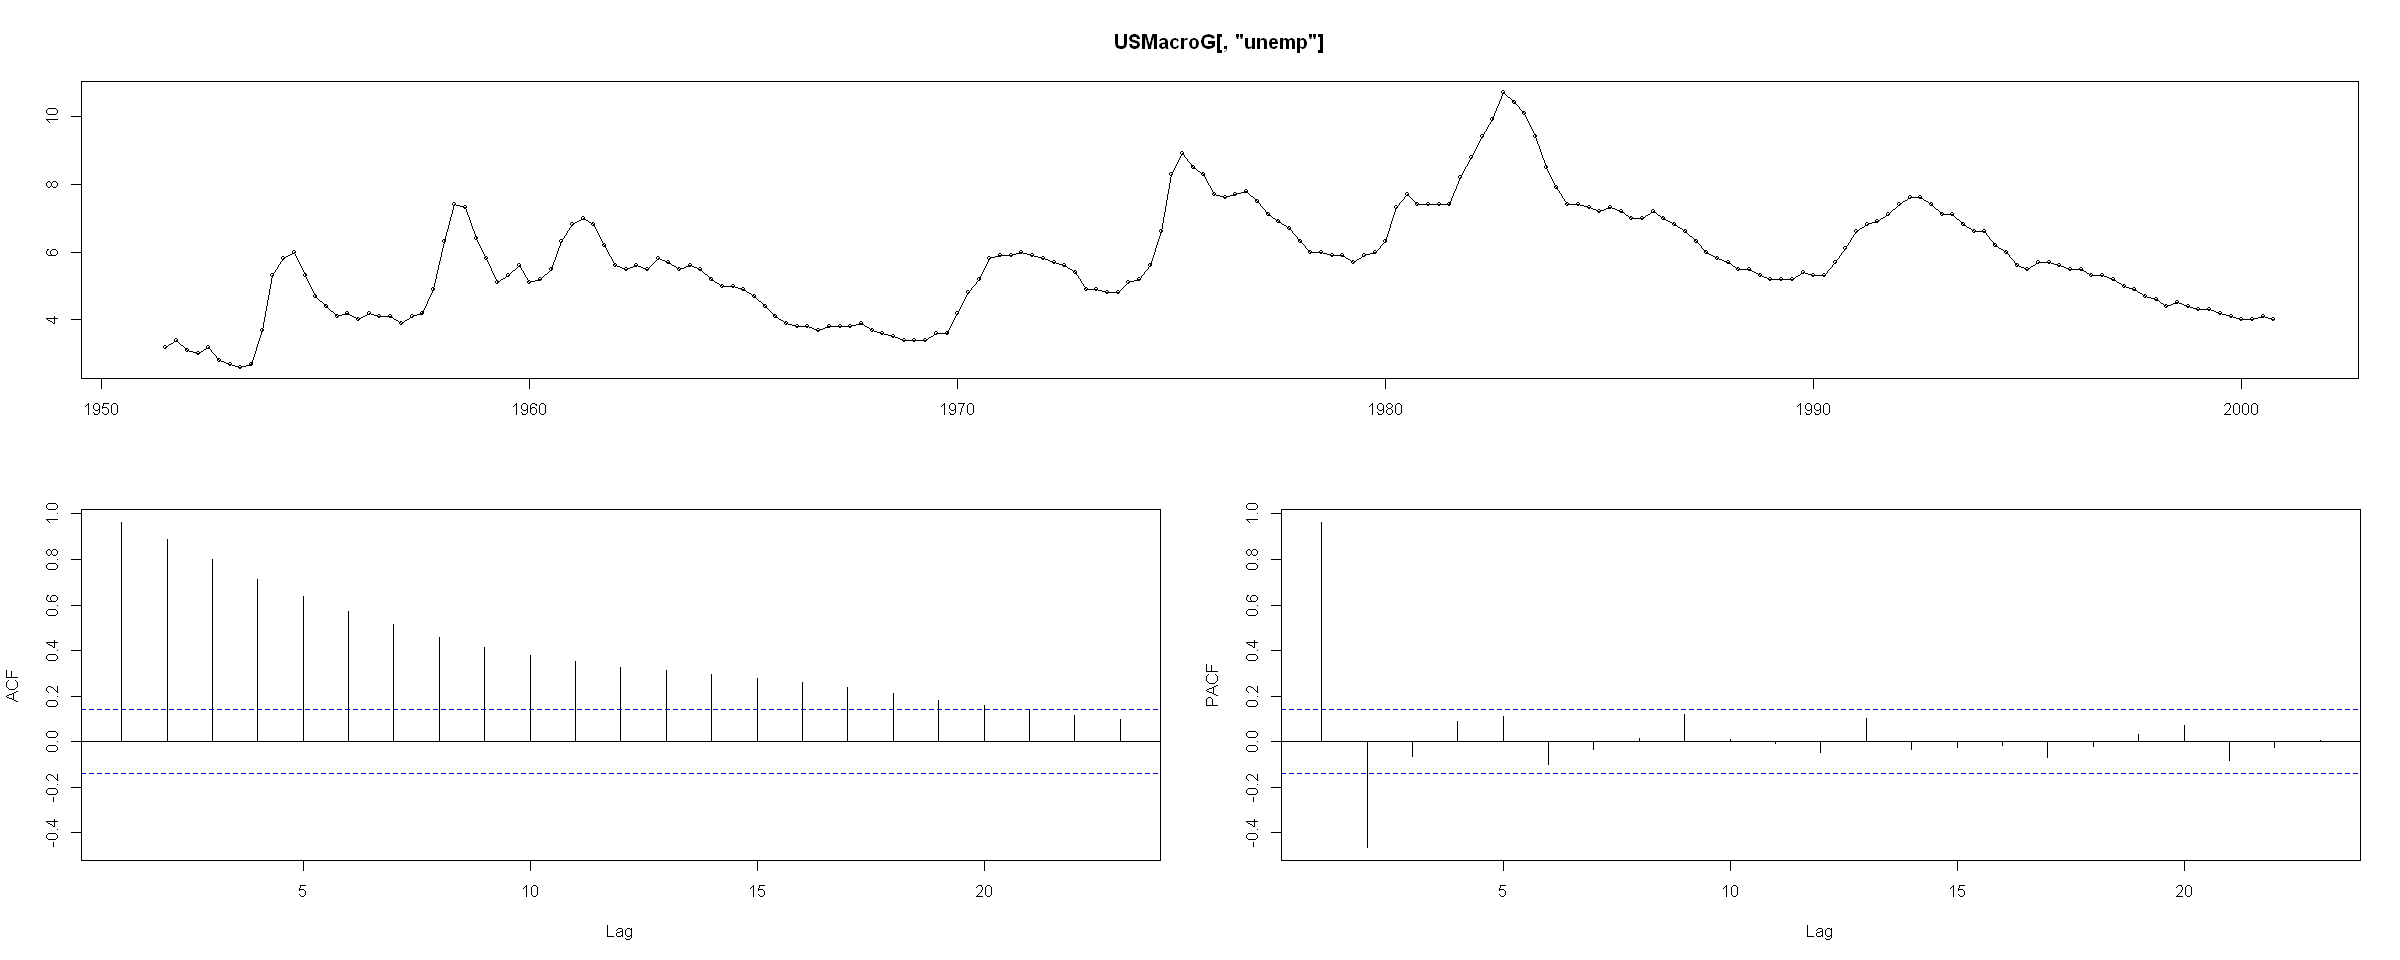

In [42]:
forecast::tsdisplay(USMacroG[, "unemp"])

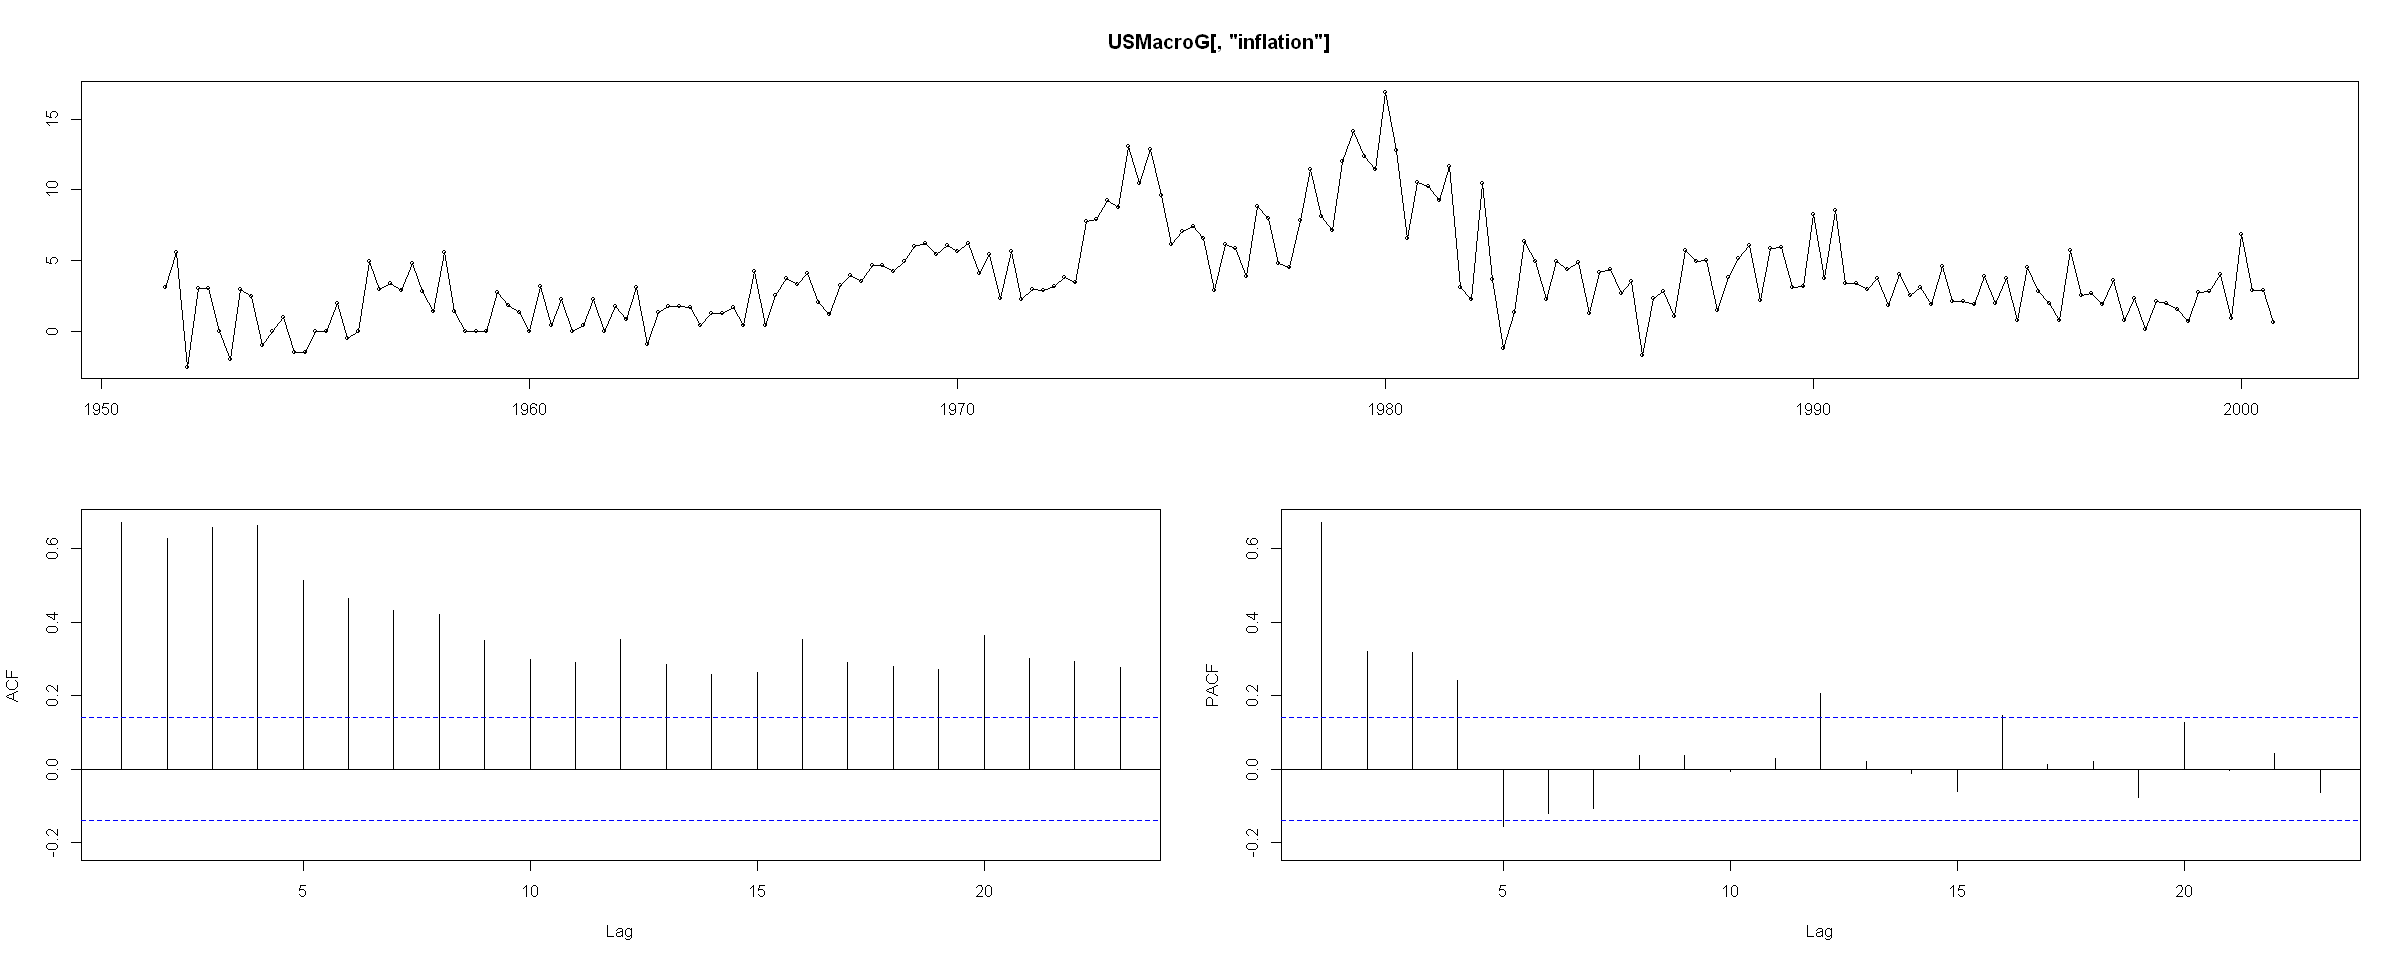

In [43]:
forecast::tsdisplay(USMacroG[, "inflation"])

The $\rm ACF$ plot of both of the series appears to be significant and declining. The decline is somewhat slow, indicating either a trend, or a unit root. There does not appear to be any seasonality in the series.

# 3. Examine the $\rm CCF$’s - do the variables appear to be correlated with one another?

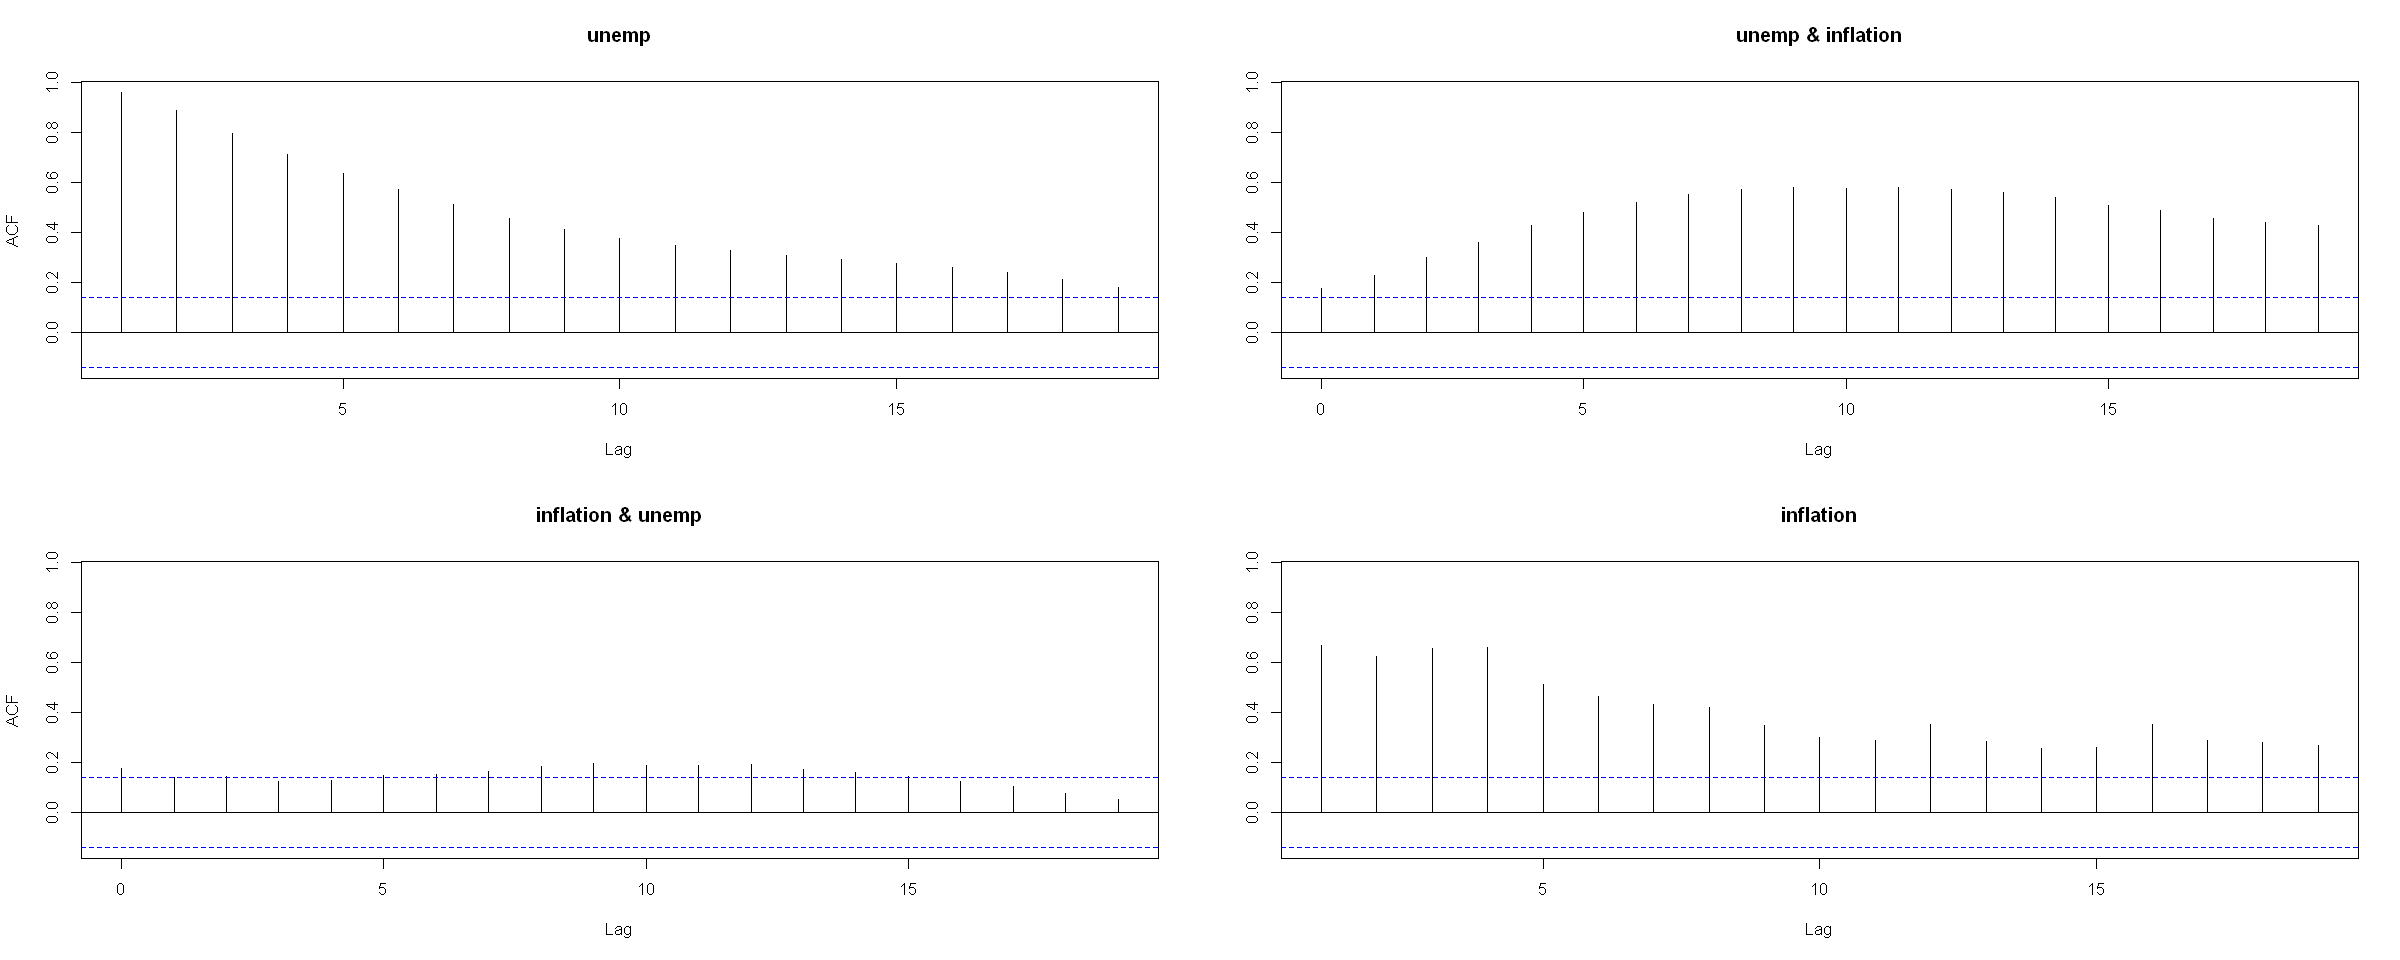

In [44]:
forecast::Acf(USMacroG[, c("unemp", "inflation")])

Note `inflation & unemp` calculates $\mathbb{C}{\rm orr} (\ Y_{inflation, t + h},  X_{unemp, t})$, we see that there is a weak correlation between inflation and the past values of unemployment. On the other hand, looking at `unemp & inflation`, there is a stronger correlation between unemployment and the past values of inflation.

# 4. Carry out unit root tests.

We will test whether the series have unit roots.

In [45]:
tseries::adf.test(USMacroG[, "unemp"], alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  USMacroG[, "unemp"]
Dickey-Fuller = -2.709, Lag order = 5, p-value = 0.2793
alternative hypothesis: stationary


In [46]:
tseries::adf.test(USMacroG[, "inflation"], alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  USMacroG[, "inflation"]
Dickey-Fuller = -2.6891, Lag order = 5, p-value = 0.2876
alternative hypothesis: stationary


In both cases, we have no grounds to reject the null hypothesis $H_0: \rho = 0$, so both of the series contain unit roots.

# 5. If needed, carry out the Engle-Granger test for cointegration.

We have determined that both of the series contain unit roots. So, we would need to create a model on the differences. On the other hand, if the series are coitnegrated, then they have a lon-run relationship, which we should also include in our model. So, we carry out the E-G cointegration test:

In [47]:
coint_res <- ts(lm(inflation ~ unemp, data = USMacroG)$res, start = 1947, frequency = 4)

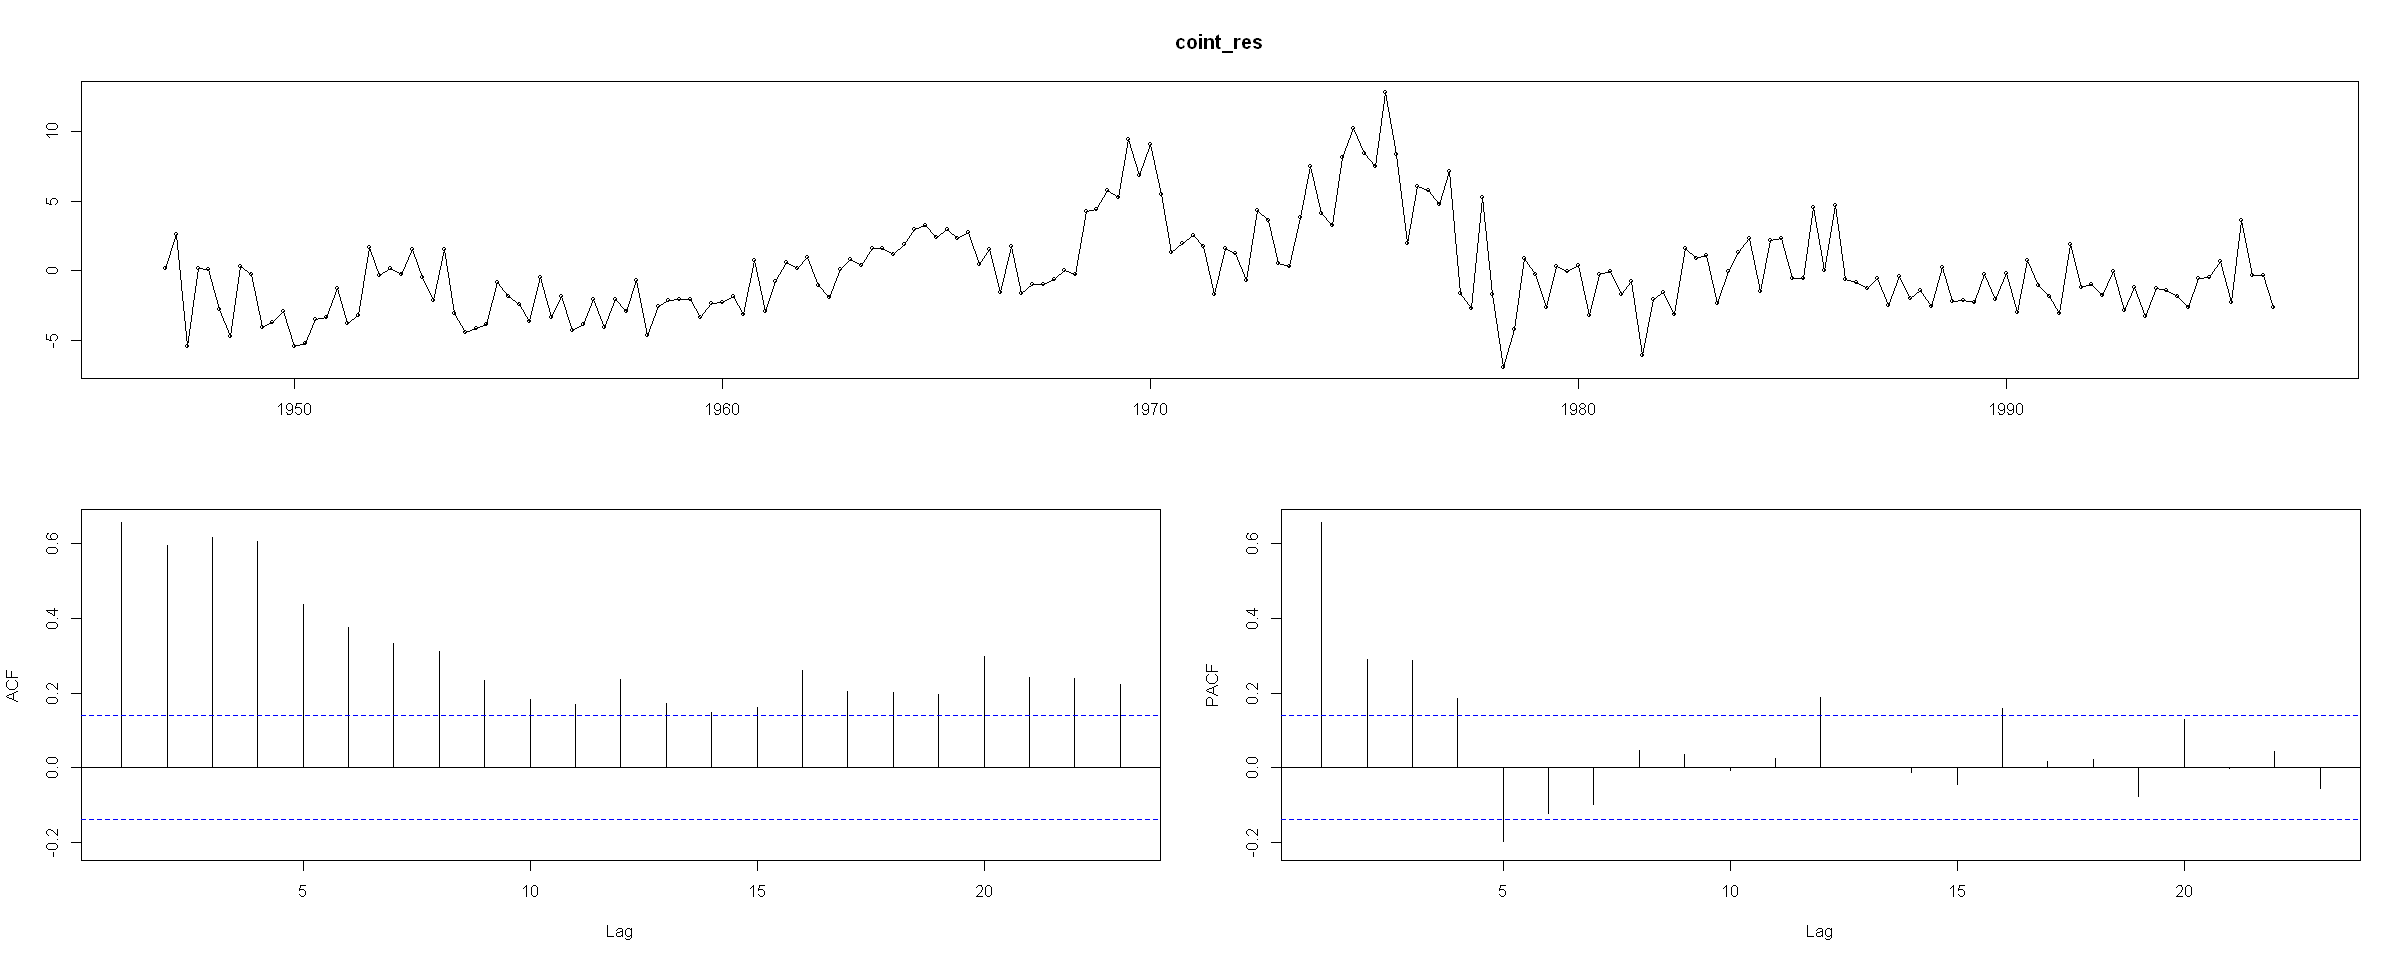

In [48]:
forecast::tsdisplay(coint_res)

We need to check, whether the residuals have a unit root.

In [49]:
library(dynlm)

**Remember:** Since we are examining the residuals - we have to exclude the constant and trend from the unit root testing equation.

In [50]:
resid_mdl <- dynlm(d(coint_res) ~ -1 + L(coint_res) + L(d(coint_res), 1:10))
round(coef(summary(resid_mdl)), 5)

Estimate Std. Error t value  Pr(>|t|)
L(coint_res)            -0.18292 0.06674    -2.74099 0.00676 
L(d(coint_res), 1:10)1  -0.45936 0.08945    -5.13548 0.00000 
L(d(coint_res), 1:10)2  -0.25550 0.09454    -2.70251 0.00756 
L(d(coint_res), 1:10)3   0.02971 0.09517     0.31219 0.75526 
L(d(coint_res), 1:10)4   0.29857 0.09336     3.19796 0.00164 
L(d(coint_res), 1:10)5   0.14744 0.09562     1.54184 0.12491 
L(d(coint_res), 1:10)6   0.05449 0.09658     0.56418 0.57335 
L(d(coint_res), 1:10)7  -0.09206 0.09630    -0.95592 0.34043 
L(d(coint_res), 1:10)8  -0.04931 0.09593    -0.51395 0.60793 
L(d(coint_res), 1:10)9  -0.01996 0.08851    -0.22555 0.82181 
L(d(coint_res), 1:10)10 -0.03257 0.07408    -0.43967 0.66071

We will remove insignificant lags to determine the appropriate order:

In [51]:
resid_mdl <- dynlm(d(coint_res) ~ -1 + L(coint_res) + L(d(coint_res), 1:4))
summary(resid_mdl)


Time series regression with "ts" data:
Start = 1948(2), End = 1996(2)

Call:
dynlm(formula = d(coint_res) ~ -1 + L(coint_res) + L(d(coint_res), 
    1:4))

Residuals:
   Min     1Q Median     3Q    Max 
-7.676 -1.525 -0.030  1.185  5.803 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
L(coint_res)          -0.16711    0.05658  -2.953  0.00354 ** 
L(d(coint_res), 1:4)1 -0.44005    0.08316  -5.292 3.36e-07 ***
L(d(coint_res), 1:4)2 -0.27751    0.08784  -3.159  0.00184 ** 
L(d(coint_res), 1:4)3 -0.03913    0.08341  -0.469  0.63948    
L(d(coint_res), 1:4)4  0.20922    0.07075   2.957  0.00350 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.176 on 188 degrees of freedom
Multiple R-squared:  0.3414,	Adjusted R-squared:  0.3239 
F-statistic: 19.49 on 5 and 188 DF,  p-value: 1.288e-15


The estimated model is:
$$
\Delta e_t = \rho e_{t-1} + \sum_{i = 1}^4 \gamma_i \Delta e_{t-i} + w_t
$$

The t-value of `L(coint_res)` is `2.953`. Since our long-run equation has one exogeneous variable, `unemp` and no trend, the critical value is `-3.37`. 

Since `2.953 > -3.37`, we have no grounds to reject $H_0: \rho  = 0$, which means that the residuals have a unit root. In other words, we do not reject the null hypothesis of **no cointegration**.

**We have concluded that the variables are not cointegrated**. This means that there is no long-run relationship between the series. This is inline with economic theory, which we have highlighted at the beginning of this example - that there is no relationship between the unemployment rate and inflation in the long-run.

# 6. Depending on the previous results, estimate an appropriate model

Since the series are $I(1)$ but not cointegrated - we will estimate a ADL model on the differences

In [52]:
mdl_1 <- dynlm(d(inflation) ~ 1 + L(d(inflation), 1:3) + L(d(unemp), 0:3), USMacroG)
summary(mdl_1)


Time series regression with "ts" data:
Start = 1952(3), End = 2000(4)

Call:
dynlm(formula = d(inflation) ~ 1 + L(d(inflation), 1:3) + L(d(unemp), 
    0:3), data = USMacroG)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2220 -1.1016 -0.0678  1.0547  4.9319 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.02038    0.14408   0.141  0.88769    
L(d(inflation), 1:3)1 -0.75013    0.06934 -10.819  < 2e-16 ***
L(d(inflation), 1:3)2 -0.61713    0.07545  -8.180 4.35e-14 ***
L(d(inflation), 1:3)3 -0.32075    0.06789  -4.724 4.54e-06 ***
L(d(unemp), 0:3)0     -0.24969    0.48368  -0.516  0.60631    
L(d(unemp), 0:3)1     -1.72675    0.58755  -2.939  0.00371 ** 
L(d(unemp), 0:3)2      0.36475    0.59578   0.612  0.54113    
L(d(unemp), 0:3)3     -1.22959    0.48684  -2.526  0.01238 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.006 on 186 degrees of freedom
Multiple R-squared:  0.

Looking at the residuals:

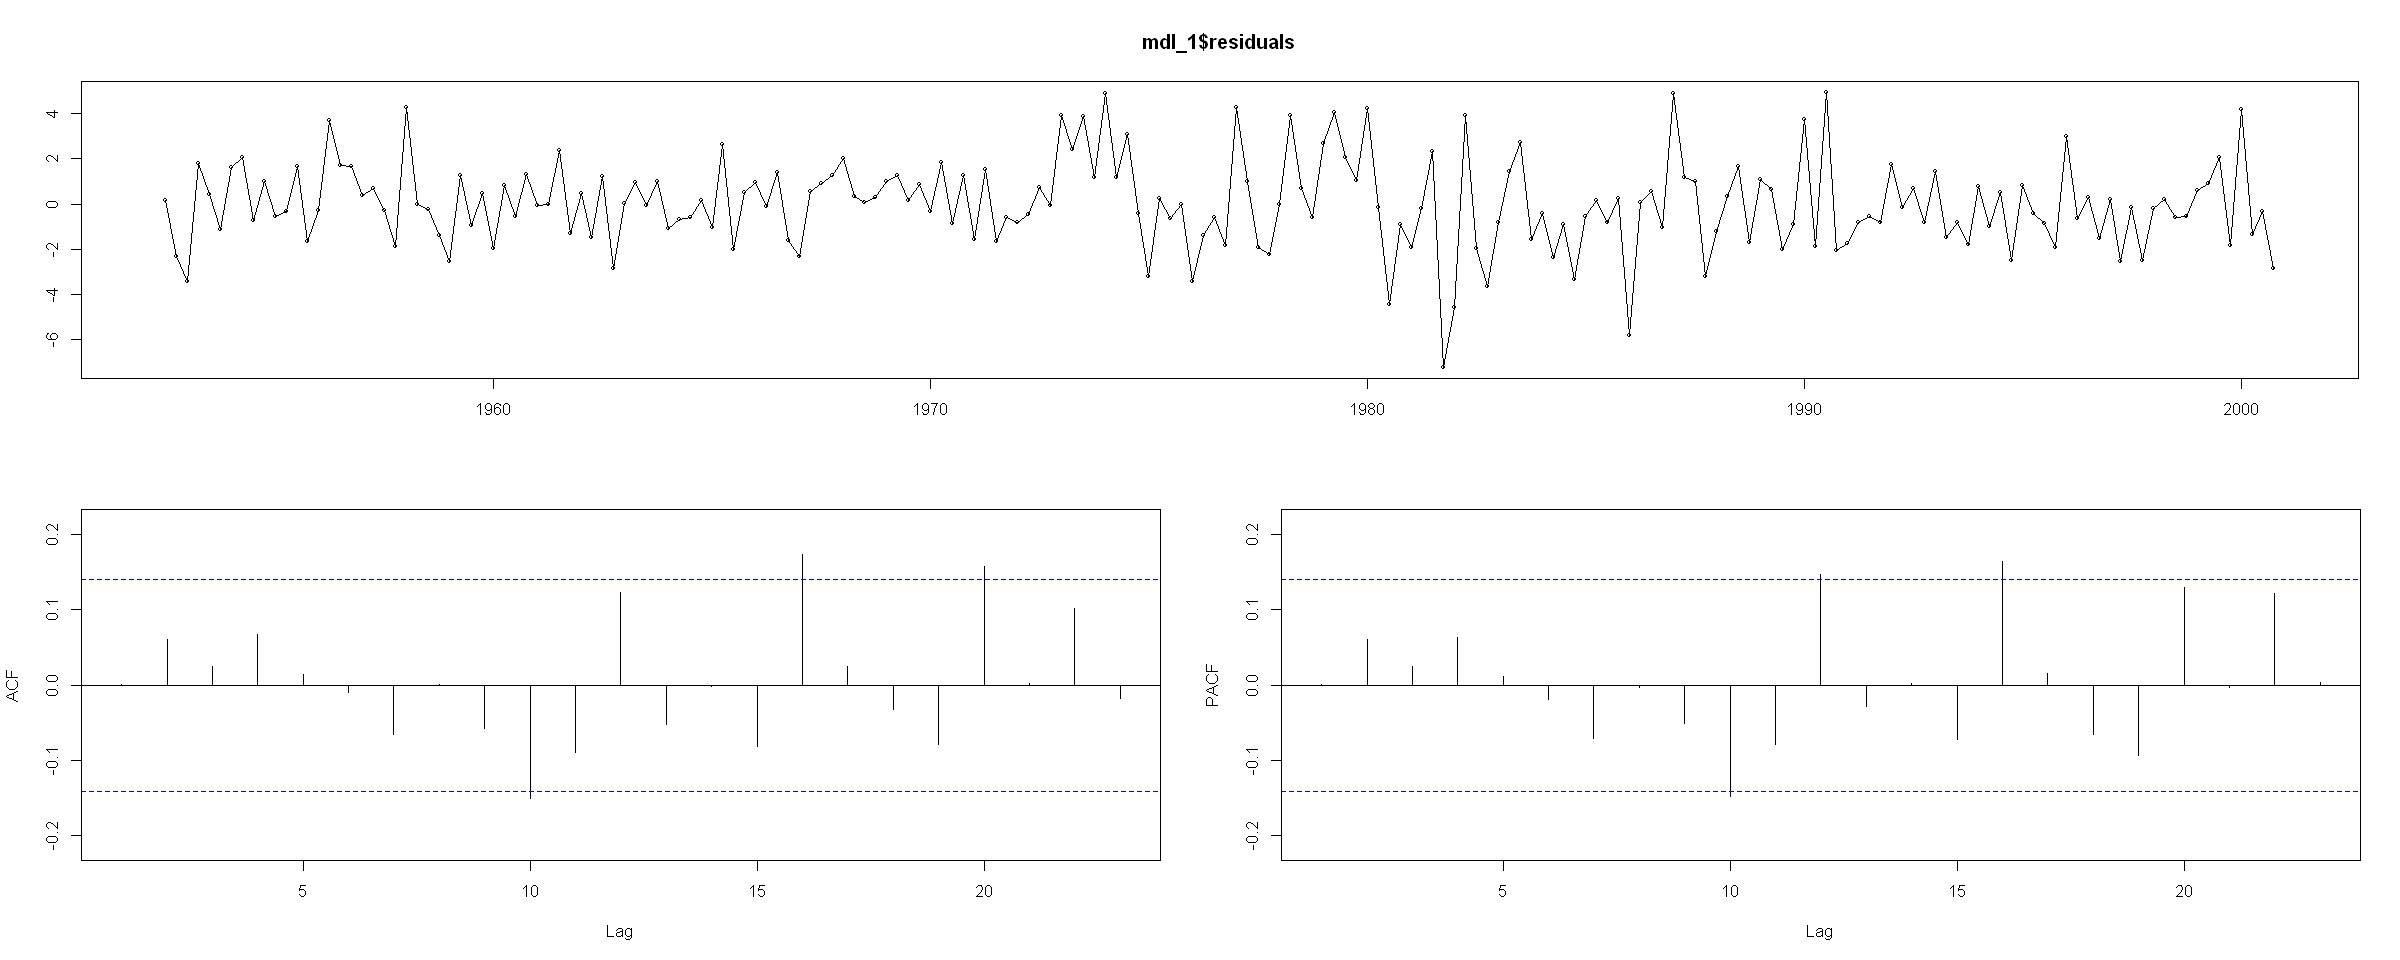

In [53]:
forecast::tsdisplay(mdl_1$residuals)

In [54]:
Box.test(mdl_1$residuals, lag = 15, fitdf = length(mdl_1$coefficients), type = "Box-Pierce")


	Box-Pierce test

data:  mdl_1$residuals
X-squared = 13.881, df = 7, p-value = 0.05334


The residuals do not appear to be correlated, though just barely. It is very likely that additional variables, or alternative model specifications may be better suited to model the short-run relationship between unemployment and inflation.

Our estimated model is:
$$
\Delta Y_t = 0.0204 -0.7501 \Delta Y_{t-1} -0.6171 \Delta Y_{t-2} -0.3208 \Delta Y_{t-3} -0.2497 \Delta X_t -1.7268 \Delta X_{t-1} + 0.3648 \Delta X_{t-2} -1.2296 \Delta X_{t-3} + \epsilon_t
$$

---
---
---

Assuming for simplicity that this is equivalent to the $\rm ADL$ model for differences with $\rho = 0$ and $\theta = 0$. If we wanted to write the model for levels as
$$
Y_t = \alpha + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \phi_3 Y_{t-3}  + \phi_4 Y_{t-4} + \beta_0 X_t + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \beta_3 X_{t-3} + \beta_4 X_{t-4} + \epsilon_t
$$
The following relationsips between the coefficients would hold:
$$
\begin{aligned}
\gamma_3 &= - \phi_4 = - 0.3208  &&\Longrightarrow&& \phi_4 = 0.3208\\
\gamma_2 &= - (\phi_3 + \phi_4) = −0.6171 &&\Longrightarrow&& \phi_3 = 0.2963\\
\gamma_1 &= - (\phi_2 + \phi_3 + \phi_4) = −0.7501 &&\Longrightarrow&& \phi_2 = 0.133\\
\rho &= \phi_1 + \phi_2 + \phi_3 + \phi_4 - 1 = 0 &&\Longrightarrow&& \phi_1 = 0.2499\\\\
\omega_4 &= - \beta_4 = -1.2296  &&\Longrightarrow&& \beta_4 = 1.2296\\
\omega_3 &= - (\beta_3 + \beta_4) = 0.3648 &&\Longrightarrow&& \beta_3 = -1.5944\\
\omega_2 &= - (\beta_2 + \beta_3 + \beta_4) = −1.7268 &&\Longrightarrow&& \beta_2 = 2.0916\\
\omega_1 &= - (\beta_1 + \beta_2 + \beta_3 + \beta_4) = −0.2497 &&\Longrightarrow&& \beta_1 = -1.4771\\
\theta &= \beta_0 + \beta_1 + \beta_2 + \beta_3 + \beta_4 = 0 &&\Longrightarrow&& \beta_0 = -0.2497
\end{aligned}
$$

**HINT:** to make it easier, iteratively use the expressions of the previous coefficients. For example:

$\gamma_1 = - (\phi_2 + \phi_3 + \phi_4) = -\phi_2 - (\phi_3 + \phi_4) = -\phi_2 + \gamma_2$

Then

$\phi_2 = -(−0.7501 - \gamma_2) = -(−0.7501 - (−0.6171)) = 0.133$

---
---
---

We will save the coefficients for both model forms as it will be easier to calculate the effects:

In [55]:
a <- 0.0204
g1 <- −0.7501
g2 <- −0.6171
g3 <- −0.3208
w1 <- −0.2497
w2 <- −1.7268
w3 <- 0.3648
w4 <- −1.2296

In [56]:
b4 <- -w4
b3 <- -(w3 - w4)
b2 <- -(w2 - w3)
b1 <- -(w1 - w2)
b0 <- w1
p4 <- -g3
p3 <- -(g2 - g3)
p2 <- -(g1 - g2)
p1 <- 1 + g1

---
---
---

## **[START: EXTRA INFO]**

We will verify whether the coefficients are correctly calculated:

In [57]:
set.seed(123)
N <- 200
#
eps <- rnorm(mean = 0, sd = 1, n = N)
X   <- sample(seq(1, 10, by = 0.1), size = N + 1, replace = TRUE)

Note the difference between $X_1$ and $\Delta X_1 = X_1 - X_0$. Since we do not observe $X_0$, we will assume that $\Delta X_1 = 0$.

In [58]:
dX <- c(0, diff(X))

Now we can simulate the series:

In [59]:
dY <- NULL
dY[1] <- a + w1 * dX[1] + eps[1]
dY[2] <- a + g1 * dY[1] + w1 * dX[2] + w2 * dX[1] + eps[2]
dY[3] <- a + g1 * dY[2] + g2 * dY[1] + w1 * dX[3] + w2 * dX[2] + w3 * dX[1] + eps[3]
dY[4] <- a + g1 * dY[3] + g2 * dY[2] + g3 * dY[1] + w1 * dX[4] + w2 * dX[3] + w3 * dX[2] + w4 * dX[1] + eps[4]
for(j in 5:N){
    dY[j] <- a + g1 * dY[j-1] + g2 * dY[j-2] + g3 * dY[j - 3] + w1 * dX[j] + w2 * dX[j - 1] + w3 * dX[j - 2] + w4 * dX[j - 3] + eps[j]    
}

In [60]:
Y <- NULL
Y[1] <- a + b0 * X[1] + eps[1]
Y[2] <- a + p1 * Y[1] + b0 * X[2] + b1 * X[1] + eps[2]
Y[3] <- a + p1 * Y[2] + p2 * Y[1] + b0 * X[3] + b1 * X[2] + b2 * X[1] + eps[3]
Y[4] <- a + p1 * Y[3] + p2 * Y[2] + p3 * dY[1] + b0 * X[4] + b1 * X[3] + b2 * X[2] + b3 * X[1] + eps[4]
for(j in 5:N){
    Y[j] <- a + p1 * Y[j-1] + p2 * Y[j-2] + p3 * Y[j - 3] + p4 * Y[j - 4] + b0 * X[j] + b1 * X[j - 1] + b2 * X[j - 2] + b3 * X[j - 3] + b4 * X[j - 4] + eps[j]    
}

In [61]:
Y <- Y[-c(1:100)]
dY <- dY[-c(1:101)]

In [62]:
dt_compare <- data.frame(diff(Y), dY)
dt_compare$DIFFERENCE <- round(diff(Y) - dY, 10)
head(dt_compare)

diff.Y.   dY        DIFFERENCE
1  2.232798  2.232798 0         
2 -8.949040 -8.949040 0         
3  9.208380  9.208380 0         
4 -0.778873 -0.778873 0         
5 -6.149624 -6.149624 0         
6  6.796163  6.796163 0

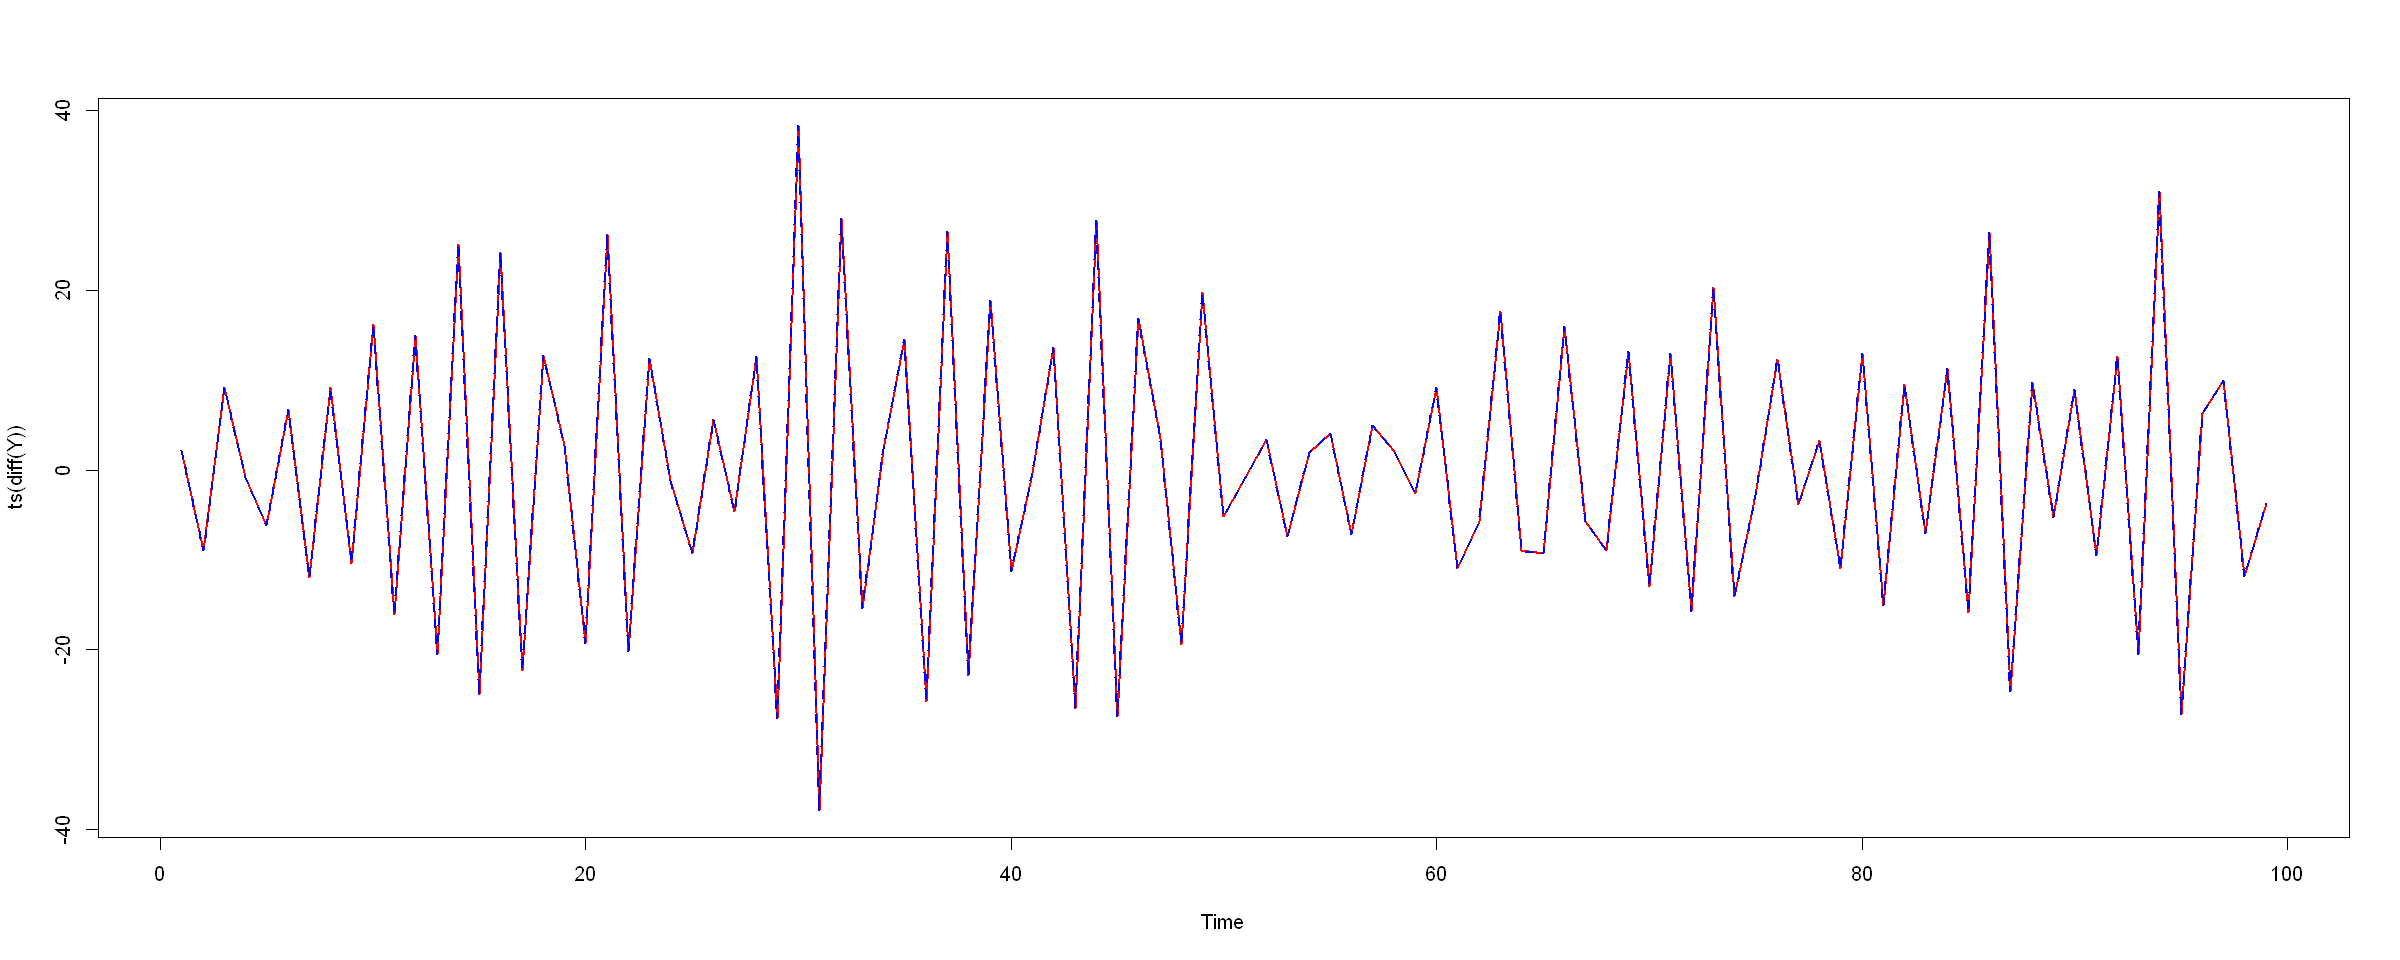

In [63]:
plot.ts(ts(diff(Y)), col = "red", lwd = 2)
lines(ts(dY), col = "blue", lty = 2, lwd = 2)

So, we can indeed see that the two models are the equivalent. This means that we can talk about the coefficients of the transformed model for the levels $X_t$ and $Y_t$ and the long-run and short-run interpretations are valid, just as if we were talking about the model on the differences.
    
If we were to estimate the model on a larger subset of the simulated $Y_t$ data

In [64]:
set.seed(123)
N <- 5000
#
eps <- rnorm(mean = 0, sd = 1, n = N)
X   <- sample(seq(1, 10, by = 0.1), size = N, replace = TRUE)

In [65]:
Y <- NULL
Y[1] <- a + b0 * X[1] + eps[1]
Y[2] <- a + p1 * Y[1] + b0 * X[2] + b1 * X[1] + eps[2]
Y[3] <- a + p1 * Y[2] + p2 * Y[1] + b0 * X[3] + b1 * X[2] + b2 * X[1] + eps[3]
Y[4] <- a + p1 * Y[3] + p2 * Y[2] + p3 * dY[1] + b0 * X[4] + b1 * X[3] + b2 * X[2] + b3 * X[1] + eps[4]
for(j in 5:N){
    Y[j] <- a + p1 * Y[j-1] + p2 * Y[j-2] + p3 * Y[j - 3] + p4 * Y[j - 4] + b0 * X[j] + b1 * X[j - 1] + b2 * X[j - 2] + b3 * X[j - 3] + b4 * X[j - 4] + eps[j]    
}

In [66]:
Y <- Y[-c(1:100)]

we would get:

In [67]:
round(
    coef(
        summary(
            dynlm(d(Y) ~ 1 + L(d(Y), 1:3) + L(d(X), 0:3), data = ts(data.frame(Y = Y, X = X[-c(1:100)])))
        )
    ), 5)

Estimate Std. Error t value    Pr(>|t|)
(Intercept)    0.01825 0.01425       1.28088 0.20029 
L(d(Y), 1:3)1 -0.75250 0.00709    -106.11951 0.00000 
L(d(Y), 1:3)2 -0.62088 0.00704     -88.15991 0.00000 
L(d(Y), 1:3)3 -0.32370 0.00344     -94.00726 0.00000 
L(d(X), 0:3)0 -0.24513 0.00497     -49.34819 0.00000 
L(d(X), 0:3)1 -1.72328 0.00612    -281.80761 0.00000 
L(d(X), 0:3)2  0.36610 0.01233      29.69683 0.00000 
L(d(X), 0:3)3 -1.22718 0.01101    -111.44010 0.00000

which are close to the true values of $\Delta Y_t$ model:

In [68]:
print(a)
print(paste0("g_ ", 1:3, " = ", c(g1, g2, g3)))
print(paste0("w_ ", 1:3, " = ", c(w1, w2, w3)))

[1] 0.0204
[1] "g_ 1 = -0.7501" "g_ 2 = -0.6171" "g_ 3 = -0.3208"
[1] "w_ 1 = -0.2497" "w_ 2 = -1.7268" "w_ 3 = 0.3648" 


Again note, that we simulated data for $Y_t$ and succesfully estimated the equivalent model for $\Delta Y_t$, which confirms that the model specifications are equivalent.

## **[END: EXTRA INFO]**

---
---
---

# 7. Assume that one of your $X$ variables exhibits a temporary unit increase for period $t + 1$. then:
## - What is the immediate effect on $Y$ (i.e. the short-run multiplier)?
## - Describe the $s$-period delay multiplier (i.e. the effect at period $t+s$) - as $s$ increases, how does the value of $Y$ change?
## - What is the long-run multiplier (i.e. the long-run effect)?    

Rewriting the coefficients for the non-differenced series and taking the partial derivatives we see that the following holds:

$
\begin{aligned}
\dfrac{\partial Y_t}{\partial X_t} &= \beta_0\\
\dfrac{\partial Y_{t+1}}{\partial X_t} &= \beta_1 + \phi_1 \dfrac{\partial Y_t}{\partial X_t} \\
\dfrac{\partial Y_{t+2}}{\partial X_t} &= \beta_2 + \phi_1 \dfrac{\partial Y_{t+1}}{\partial X_t} + \phi_2 \dfrac{\partial Y_t}{\partial X_t} \\
\dfrac{\partial Y_{t+3}}{\partial X_t} &= \beta_3 + \phi_1 \dfrac{\partial Y_{t+2}}{\partial X_t} + \phi_2 \dfrac{\partial Y_{t+1}}{\partial X_t} + \phi_3 \dfrac{\partial Y_{t}}{\partial X_t} \\
\dfrac{\partial Y_{t+4}}{\partial X_t} &= \beta_4 + \phi_1 \dfrac{\partial Y_{t+3}}{\partial X_t} + \phi_2 \dfrac{\partial Y_{t+2}}{\partial X_t} + \phi_3 \dfrac{\partial Y_{t+1}}{\partial X_t} + \phi_4 \dfrac{\partial Y_{t}}{\partial X_t}\\
\vdots\\
\dfrac{\partial Y_{t+k}}{\partial X_t} &= \phi_1 \dfrac{\partial Y_{t+k-1}}{\partial X_t} + \phi_2 \dfrac{\partial Y_{t+k-2}}{\partial X_t} + \phi_3 \dfrac{\partial Y_{t+k-3}}{\partial X_t} + \phi_4 \dfrac{\partial Y_{t+k-4}}{\partial X_t}
\end{aligned}
$

Unfortunately, the expressions themselves aren't as easy to simplify. Nevertheless, we can calculate the marginal effects:

In [69]:
MES    <- b0
MES[2] <- b1 + p1 * MES[1]
MES[3] <- b2 + p1 * MES[2] + p2 * MES[1]
MES[4] <- b3 + p1 * MES[3] + p2 * MES[2] + p3 * MES[1]
MES[5] <- b4 + p1 * MES[4] + p2 * MES[3] + p3 * MES[2] + p4 * MES[1]
for(j in 6:35){
    MES[j] <-  p1 * MES[j-1] + p2 * MES[j - 2] + p3 * MES[j - 3] + p4 * MES[j - 4]
}

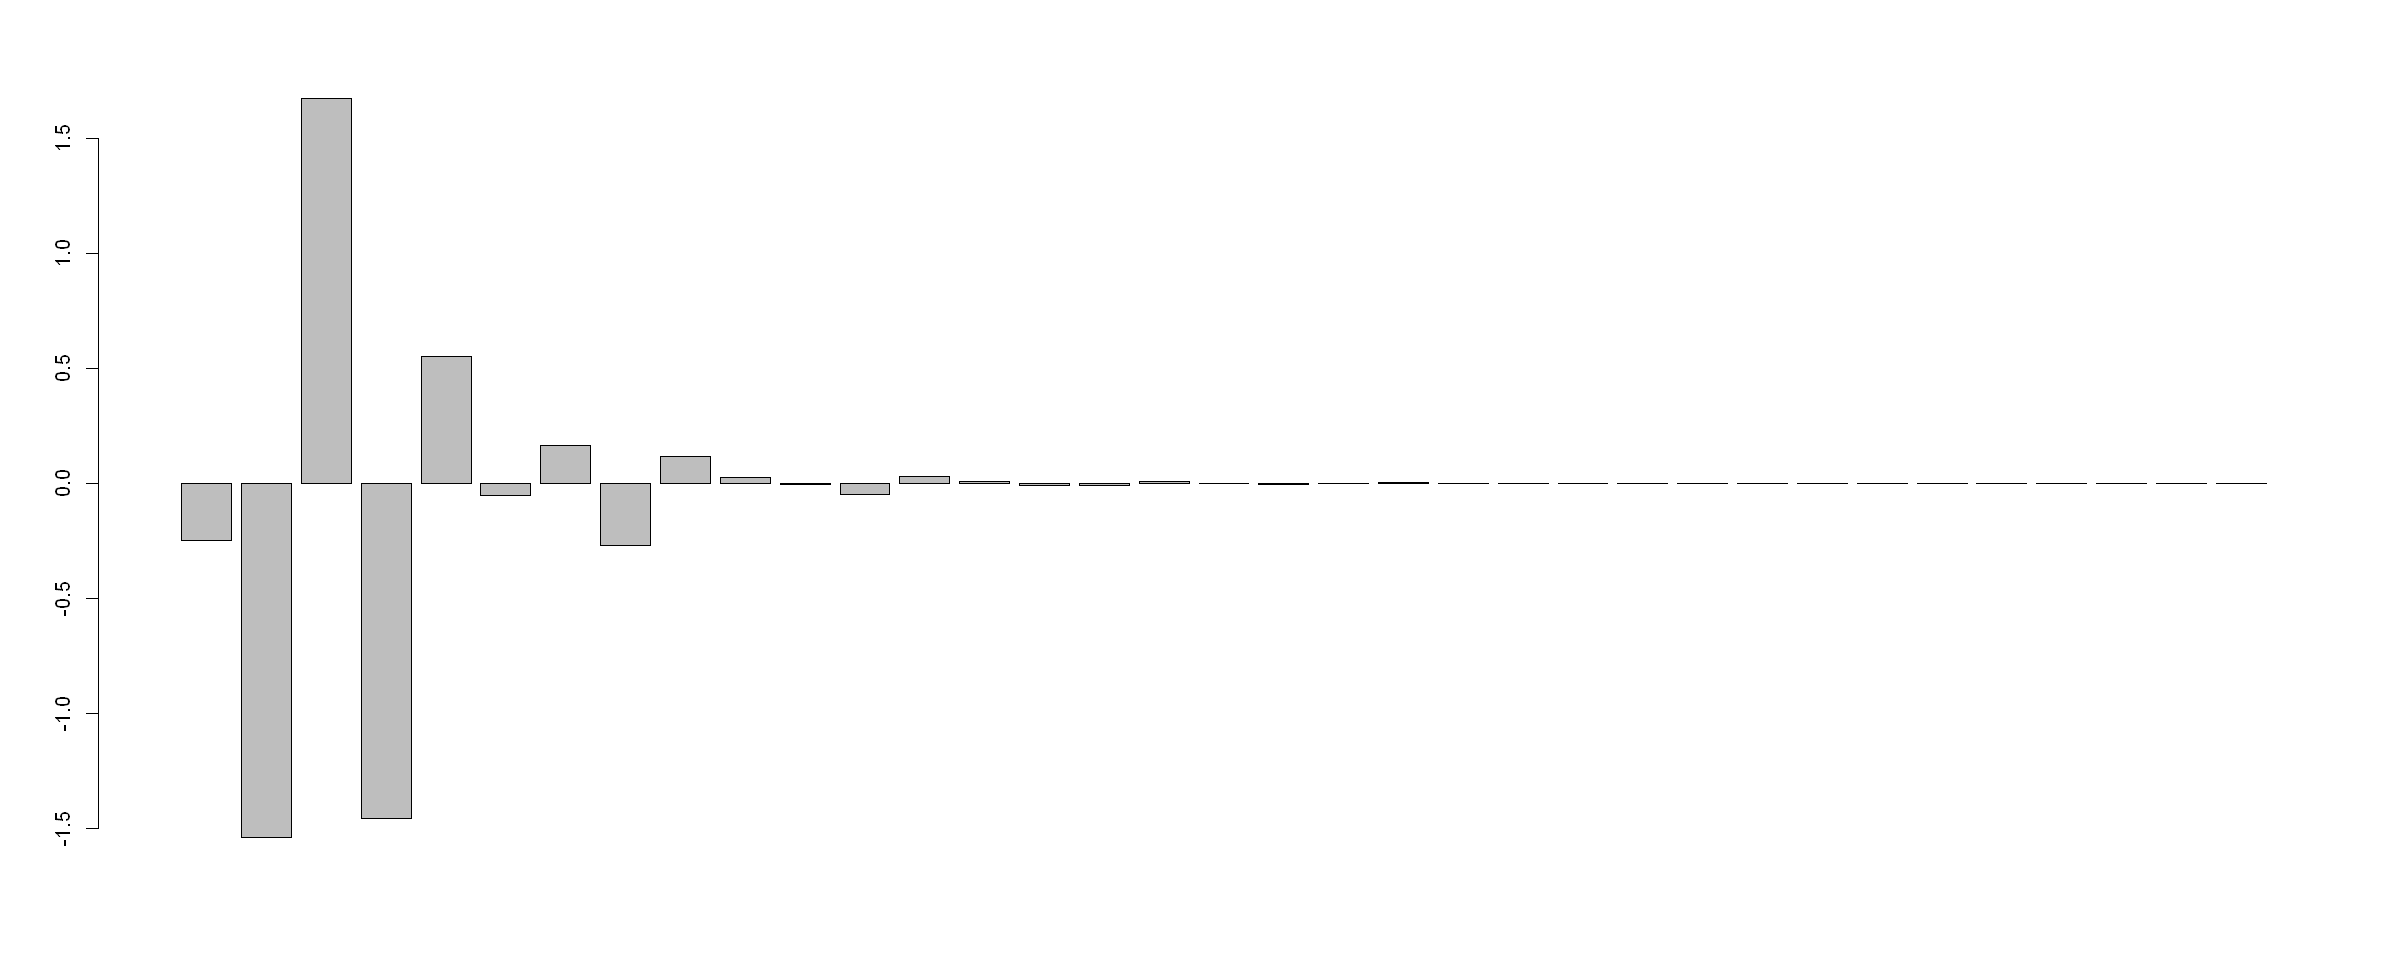

In [70]:
barplot(MES)

In [71]:
print(round(MES, 4))

 [1] -0.2497 -1.5395  1.6737 -1.4549  0.5524 -0.0534  0.1659 -0.2687  0.1163
[10]  0.0254 -0.0046 -0.0495  0.0318  0.0081 -0.0099 -0.0078  0.0094  0.0010
[19] -0.0040 -0.0006  0.0026 -0.0003 -0.0012  0.0002  0.0007 -0.0003 -0.0003
[28]  0.0002  0.0001 -0.0001 -0.0001  0.0001  0.0000  0.0000  0.0000


We see that:

- The short-run (i.e. immediate) effect is $\beta_0 = −0.2497$;
- The $s$-period interim multiplier is decreasing and oscilating between positive and negative values;
- The long-run marginal effect of a temporary change in $X$ is zero.

Note that we are talking about the **change** in $Y$ in response to a change in $X$ and not the expected value of $Y$ given a new value (change) of $X$. The zero-value simply means that $Y$ reverts back to its expected value.

---
---
---

## **[START: EXTRA INFO]**

Unfortunately, `dynlm` does nto have a correct implementation of prediction, see [this answer on stackoverflow](https://stats.stackexchange.com/a/6775).

In [72]:
library(dynlm)

set.seed(1)
#Create AR(1) dependant variable
y<-arima.sim(model=list(ar=c(.9)),n=10) 
#Create independant variables
A<-rnorm(10) 
B<-rnorm(10)
C<-rnorm(10)
# Add relationship to independant variables 
y<-y+.5*A+.2*B-.3*C
data=cbind(y,A,B,C)
#Fit linear model
model<-dynlm(y~A+B+C+L(y,1), data = data)

In [73]:
t(predict(model))

2        3        4        5        6        7        8        9       
[1,] 3.500667 2.411196 2.627915 2.813815 2.468595 1.733852 2.114553 1.423225
     10      
[1,] 1.470738

Predict the values using the exact same dataset that was used in model fitting:

In [74]:
t(predict(model,newdata = data))

1        2        3        4       5        6        7      8       
[1,] 2.162833 3.706358 2.978142 2.13743 3.258238 1.953456 1.3671 2.454763
     9         10      
[1,] 0.8448223 1.876244

The values are not the same.

To adress this, you would need to add the lagged variables in the dataset.

In [75]:
newdata <- ts(cbind(A,B,C), start = start(y), freq = frequency(y))
newdata <- cbind(lag(y,-1), newdata)

In [76]:
colnames(newdata) <- c("y","A","B","C")

In [77]:
t(predict(model,newdata = newdata))

1  2        3        4        5        6        7        8        9       
[1,] NA 3.500667 2.411196 2.627915 2.813815 2.468595 1.733852 2.114553 1.423225
     10       11
[1,] 1.470738 NA

Unfortunately, if there are variables with a higher lag order - this method does not work and a custom function is needed. An alternative package could be employed for forecasting `dyn`.

For a forecasting examples - see the [documentation](https://cran.r-project.org/web/packages/dyn/dyn.pdf).

In [78]:
library(dyn)

Warning message:
"package 'dyn' was built under R version 3.5.3"

In [79]:
mdl_1_v2 <- dyn$lm(diff(inflation) ~ 1 + lag(diff(inflation), -1) + lag(diff(inflation), -2) + lag(diff(inflation), -3) 
                   + diff(unemp) + lag(diff(unemp), -1) + lag(diff(unemp), -2) + lag(diff(unemp), -3), data = USMacroG)

In [80]:
coef(summary(mdl_1_v2))

Estimate    Std. Error t value     Pr(>|t|)    
(Intercept)               0.02037578 0.14408064   0.1414193 8.876918e-01
lag(diff(inflation), -1) -0.75013311 0.06933799 -10.8185009 1.798035e-21
lag(diff(inflation), -2) -0.61713471 0.07544724  -8.1796860 4.349545e-14
lag(diff(inflation), -3) -0.32075234 0.06789172  -4.7244692 4.536549e-06
diff(unemp)              -0.24968987 0.48368374  -0.5162255 6.063101e-01
lag(diff(unemp), -1)     -1.72675377 0.58755090  -2.9389007 3.711116e-03
lag(diff(unemp), -2)      0.36475285 0.59577802   0.6122294 5.411337e-01
lag(diff(unemp), -3)     -1.22958924 0.48684192  -2.5256437 1.238333e-02

We can compare with the `dynlm` model coefficients to verify that they are the same:

In [81]:
coef(summary(mdl_1))

Estimate    Std. Error t value     Pr(>|t|)    
(Intercept)            0.02037578 0.14408064   0.1414193 8.876918e-01
L(d(inflation), 1:3)1 -0.75013311 0.06933799 -10.8185009 1.798035e-21
L(d(inflation), 1:3)2 -0.61713471 0.07544724  -8.1796860 4.349545e-14
L(d(inflation), 1:3)3 -0.32075234 0.06789172  -4.7244692 4.536549e-06
L(d(unemp), 0:3)0     -0.24968987 0.48368374  -0.5162255 6.063101e-01
L(d(unemp), 0:3)1     -1.72675377 0.58755090  -2.9389007 3.711116e-03
L(d(unemp), 0:3)2      0.36475285 0.59577802   0.6122294 5.411337e-01
L(d(unemp), 0:3)3     -1.22958924 0.48684192  -2.5256437 1.238333e-02

For a forecasting examples - see the [documentation](https://cran.r-project.org/web/packages/dyn/dyn.pdf).

In [82]:
newdata <- tail(USMacroG[, c("inflation", "unemp")], 5)

We can exmaine how the forecasts are created:

In [83]:
predict(mdl_1_v2, newdata = newdata)

          Qtr1      Qtr2      Qtr3      Qtr4
2000        NA        NA        NA 0.5130021
2001        NA        NA        NA          

In [84]:
tail(predict(mdl_1_v2), 1)

          Qtr4
2000 0.5130021

And now we can create our own forecasts:

In [85]:
newdata[, 1] <- 0
newdata[, 2] <- 0

In [86]:
h = 100

In [87]:
newdata_temp <- newdata
newdata_perm <- newdata
for(i in 1:h){
    newdata_temp <- rbind(newdata_temp, c(NA, newdata[5, 2]))
    newdata_perm <- rbind(newdata_perm, c(NA, newdata[5, 2] + 1))
}
newdata_temp[6, 2] <- newdata_temp[6, 2]  + 1

In [88]:
newdata_temp <- ts(newdata_temp)
newdata_perm <- ts(newdata_perm)

In [89]:
for(i in 1:h){
    prd <- predict(mdl_1_v2, newdata = newdata_temp)
    newdata_temp[5 + i, 1] <- tail(prd[!is.na(prd)], 1)
    #
    prd <- predict(mdl_1_v2, newdata = newdata_perm)
    newdata_perm[5 + i, 1] <- tail(prd[!is.na(prd)], 1)
}

In [90]:
t(tail(newdata_temp, 10))

[,1]       [,2]        [,3]       [,4]       [,5]      [,6]       
inflation 0.03919178 0.002661968 0.03705197 0.00467644 0.0351555 0.006461819
unemp     0.00000000 0.000000000 0.00000000 0.00000000 0.0000000 0.000000000
          [,7]      [,8]        [,9]       [,10]      
inflation 0.0334747 0.008044159 0.03198505 0.009446551
unemp     0.0000000 0.000000000 0.00000000 0.000000000

In [91]:
t(tail(newdata_perm, 10))

[,1]       [,2]       [,3]       [,4]      [,5]       [,6]      
inflation 0.02951328 0.01177353 0.02847414 0.0127518 0.02755317 0.01361883
unemp     1.00000000 1.00000000 1.00000000 1.0000000 1.00000000 1.00000000
          [,7]       [,8]       [,9]       [,10]     
inflation 0.02673693 0.01438725 0.02601352 0.01506828
unemp     1.00000000 1.00000000 1.00000000 1.00000000

The temporary increase in $X$ leads to a temporary change in $Y$:

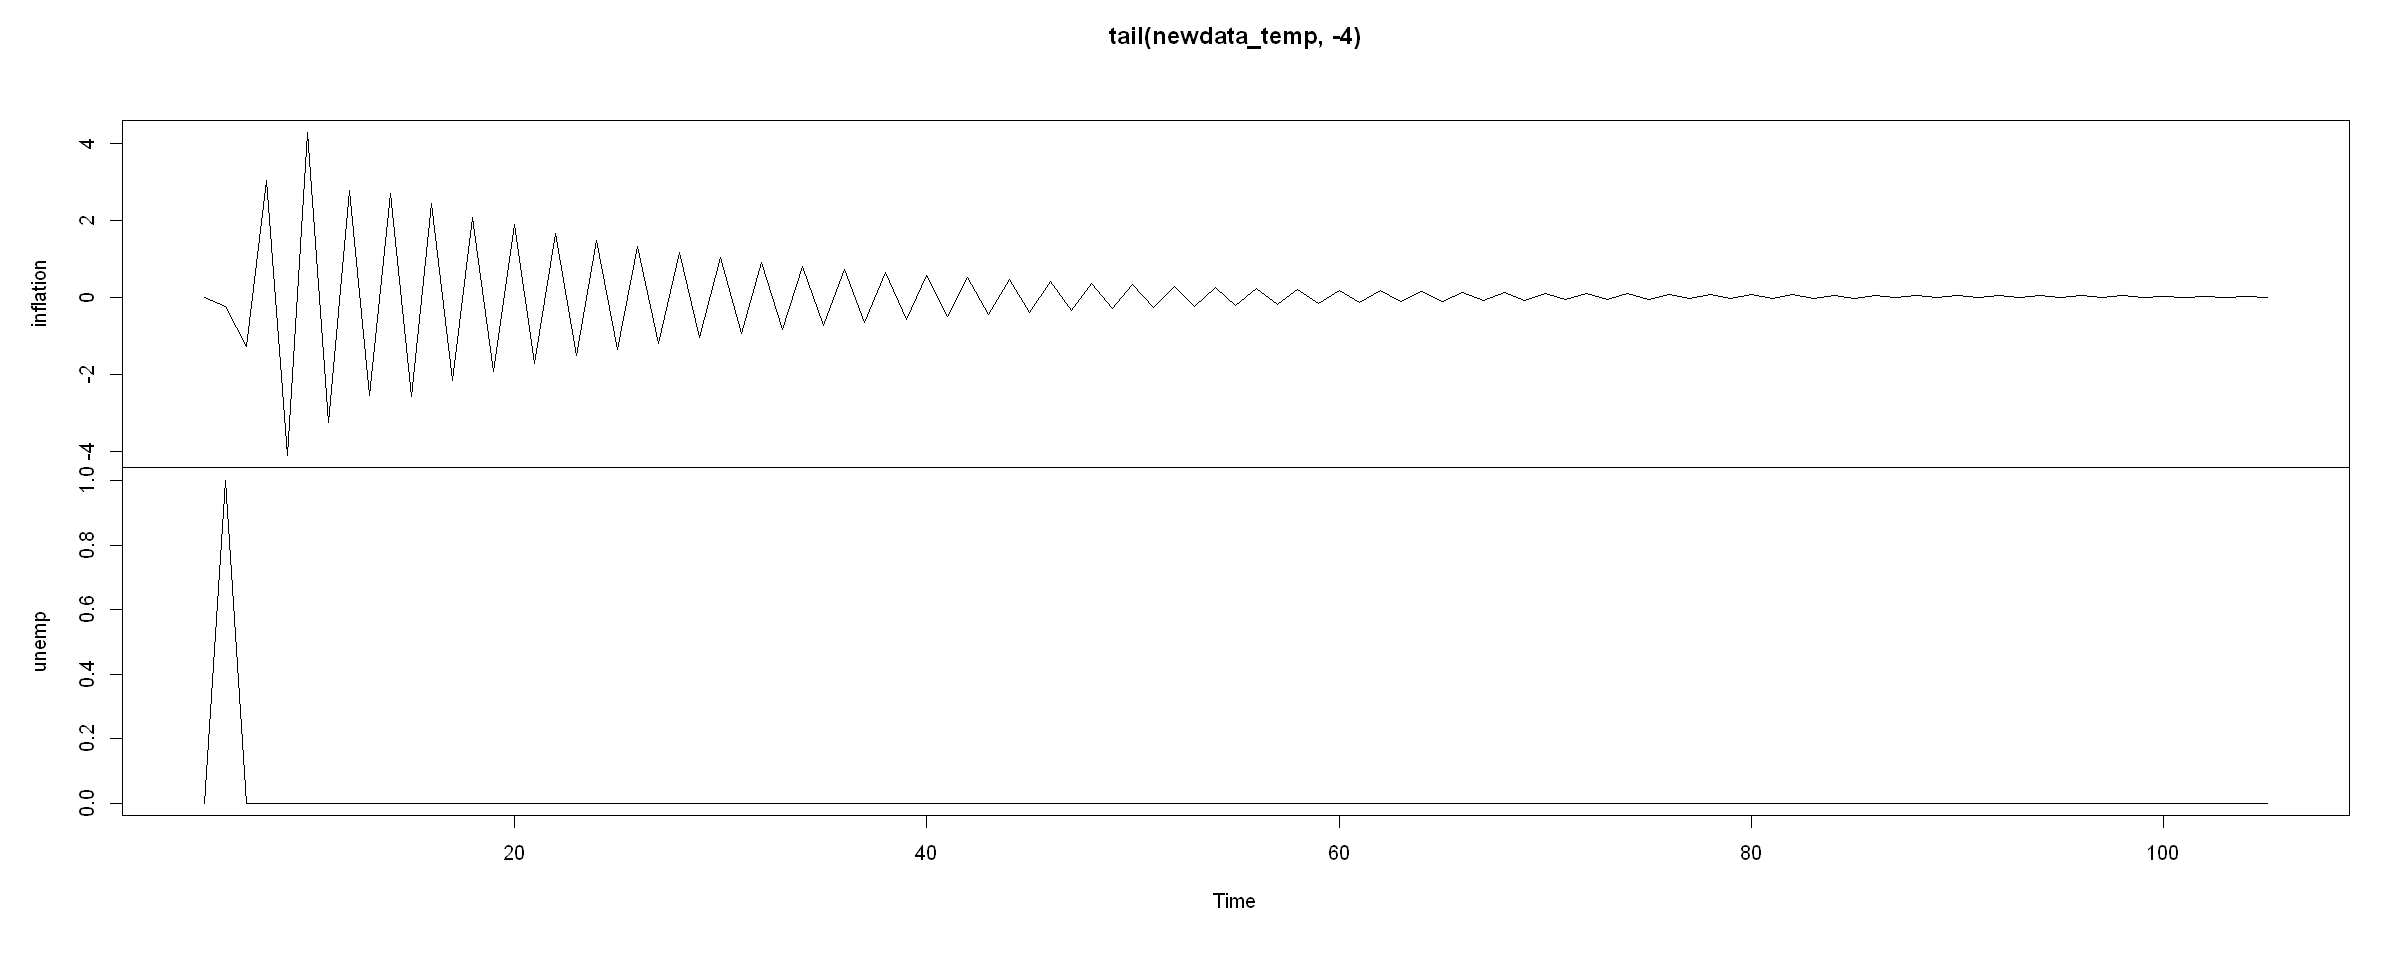

In [92]:
plot.ts(tail(newdata_temp, -4))

Note that this is not exactly the temporary and permanent change effects, since we use some previous historical (or some past manually-defined, zero-valued) data.

## **[END: EXTRA INFO]**

---
---
---

# 8. Assume that one of your $X$ variables exhibits a **permanent** unit increase after period $t$, so that $... = X_{t-1} = X$ and $X_t = X_{t+1} = ... = X+1$. Then:
## - What is the immediate effect on $Y$ (i.e. the short-run multiplier)?
## - Describe the $s$-period delay multiplier (i.e. the effect at period $t+s$) - as $s$ increases, how does the value of $Y$ change?
## - What is the long-run multiplier (i.e. the long-run effect)?    

We may make the initial assumption that we can apply the same techniques as before for the long-run relationship. As mentioned before, since the series are $I(1)$ and not cointegrated, the long-run relationship does not exist. Newertheless, if we were to look at it as for the stationary variable case, we would get that:

$
\begin{aligned}
\dfrac{\partial Y_t}{\partial X_t} &= \beta_0\\
\dfrac{\partial Y_{t+1}}{\partial X_t} + \dfrac{\partial Y_{t+1}}{\partial X_{t+1}}&= 
\beta_0 + \beta_1 + \phi_1 \dfrac{\partial Y_t}{\partial X_t}\\
\dfrac{\partial Y_{t+2}}{\partial X_t} + \dfrac{\partial Y_{t+2}}{\partial X_{t+1}} + \dfrac{\partial Y_{t+2}}{\partial X_{t+2}} &= 
\beta_0 + \beta_1 + \beta_2 + \phi_1 \left[ \dfrac{\partial Y_{t+1}}{\partial X_t} + \dfrac{\partial Y_{t+1}}{\partial X_{t+1}} \right] + \phi_2 \dfrac{\partial Y_t}{\partial X_t}\\
\vdots
\end{aligned}
$

Note that since $\theta = \beta_0 + \beta_1 + \beta_2 + \beta_3 + \beta_4 = 0$ the permanent change in $X_t$ cancels out and only the effect from the lagged values remain.

In [93]:
MES    <- b0
MES[2] <- b0 + b1 + p1 * MES[1]
MES[3] <- b0 + b1 + b2 + p1 * MES[2] + p2 * MES[1]
MES[4] <- b0 + b1 + b2 + b3 + p1 * MES[3] + p2 * MES[2] + p3 * MES[1]
MES[5] <- b0 + b1 + b2 + b3 + b4 + p1 * MES[4] + p2 * MES[3] + p3 * MES[2] + p4 * MES[1]
for(j in 6:20){
    MES[j] <- b0 + b1 + b2 + b3 + b4 + p1 * MES[j-1] + p2 * MES[j - 2] + p3 * MES[j - 3] + p4 * MES[j - 4]
}

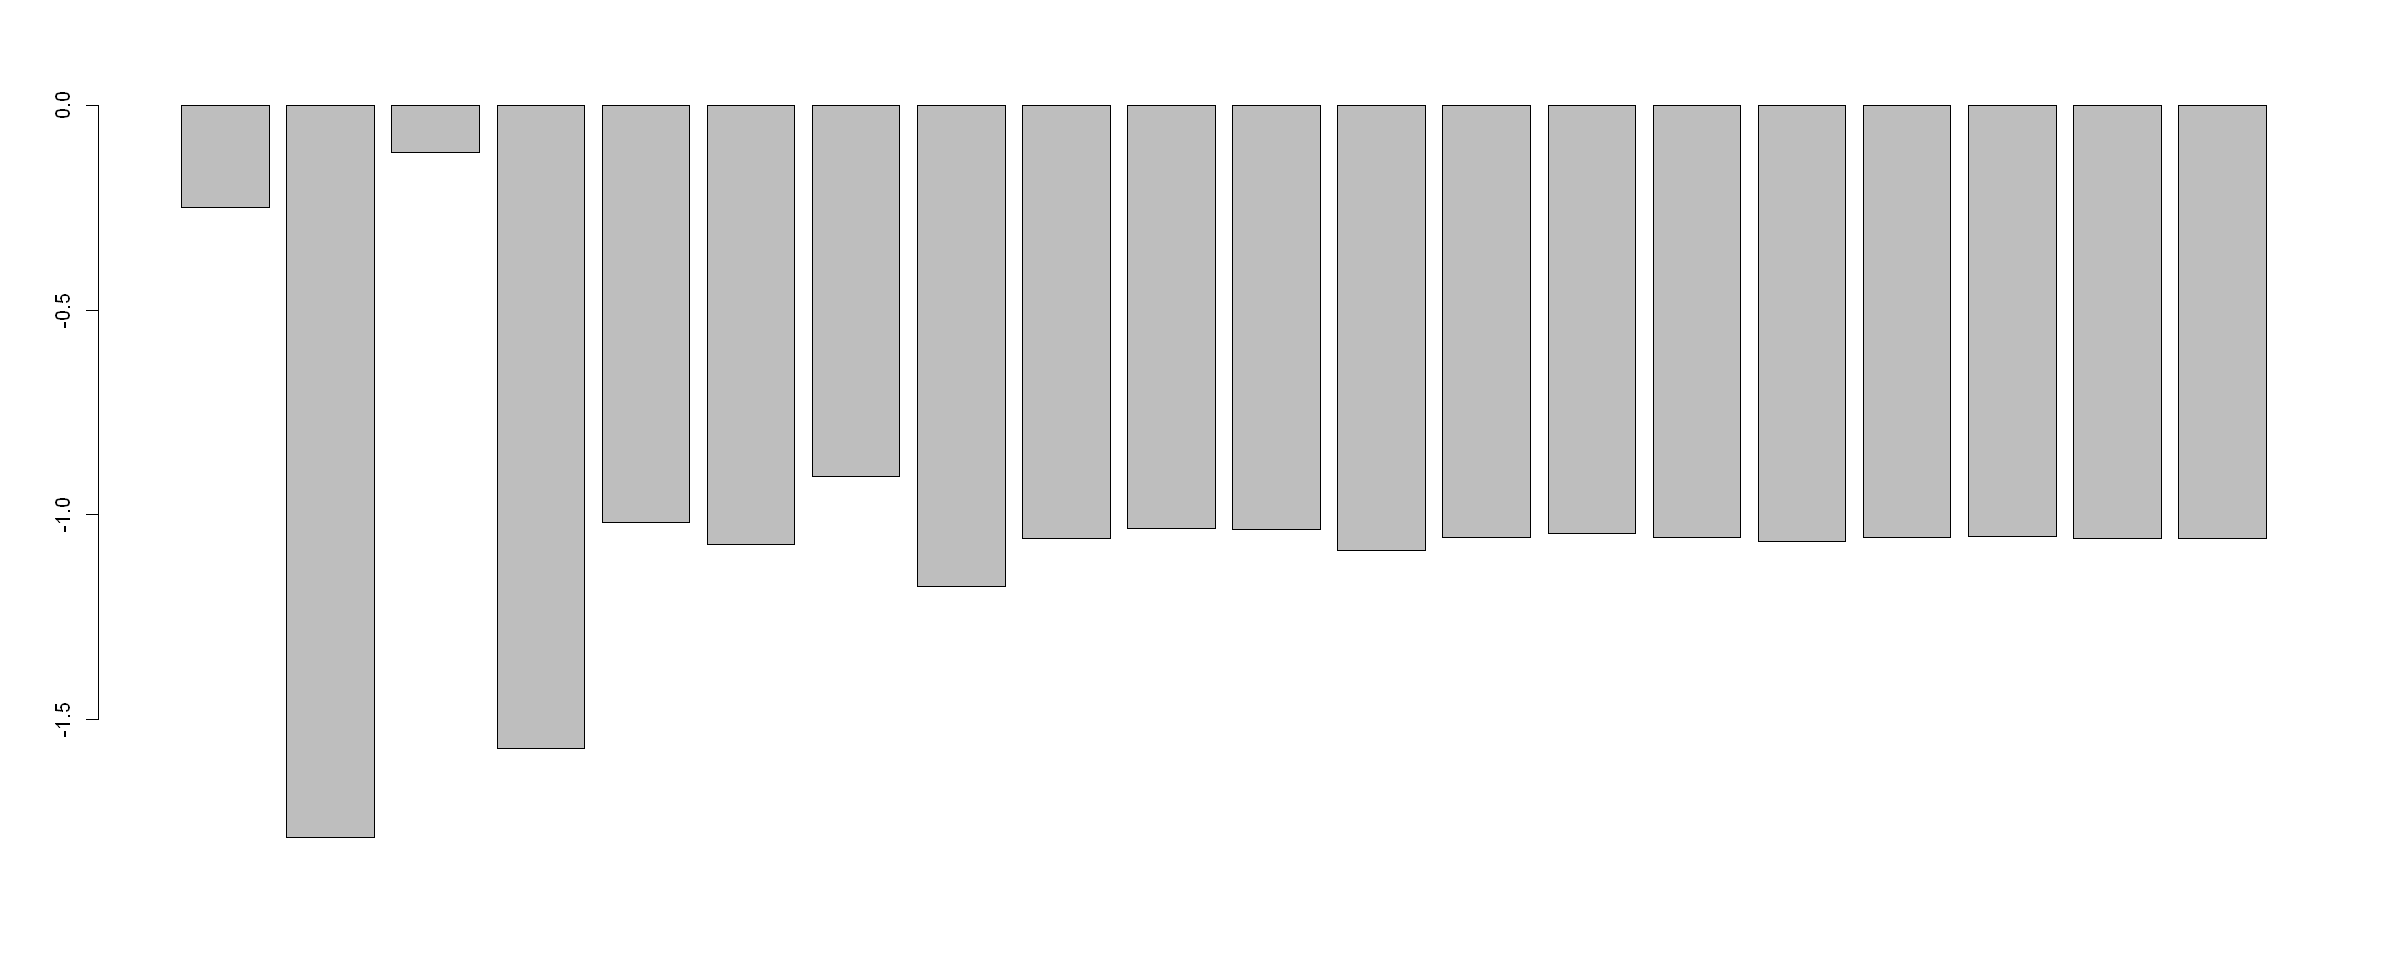

In [94]:
barplot(MES)

In [95]:
print(MES)

 [1] -0.2497000 -1.7892000 -0.1155312 -1.5704210 -1.0180576 -1.0714858
 [7] -0.9055441 -1.1742446 -1.0579552 -1.0326029 -1.0371827 -1.0866979
[13] -1.0548634 -1.0467174 -1.0565883 -1.0644236 -1.0550683 -1.0540840
[19] -1.0580819 -1.0586916


This appears puzzling at first - why is the  long-run multiplier around `-1.054`? If we continue to employ a similar logic as we would do for the levels (i.e. $Y_t$ and $X_t$) if they were stationary.

Since the differences are stationary, we can see what the expected values of $\Delta Y$ and $\Delta X$ are by taking the expectations from both sides of:
$$
\Delta Y_t = 0.0204 -0.7501 \Delta Y_{t-1} -0.6171 \Delta Y_{t-2} -0.3208 \Delta Y_{t-3} -0.2497 \Delta X_t -1.7268 \Delta X_{t-1} + 0.3648 \Delta X_{t-2} -1.2296 \Delta X_{t-3} + \epsilon_t
$$

which gives us:
$$
\begin{aligned}
\Delta Y &= \dfrac{0.0204}{1 + 0.7501 + 0.6171 + 0.3208} + \dfrac{−0.2497 −1.7268 + 0.3648 −1.2296}{1 + 0.7501 + 0.6171 + 0.3208} \Delta X = 0.00759 - 1.05703 \Delta X
\end{aligned}
$$

Now we see a slightly different interpretation - if $\Delta X = 1$, then $\Delta Y = 0.00759 - 1.05703 = -1.04944$.

But does it make sense to define an "expected value" of a change (i.e. $\Delta Y$ or $\Delta X$)?

Again, if we re-write the differences in terms of levels, then since $\rho = 0$ and $\theta = 0$, we would not get any long-run relationships (as we would expect from non-cointegrated DS series.).

The closest thing to a long-run relationship analysis would be to forecast how the forecasts change in regards to a change in $X$:

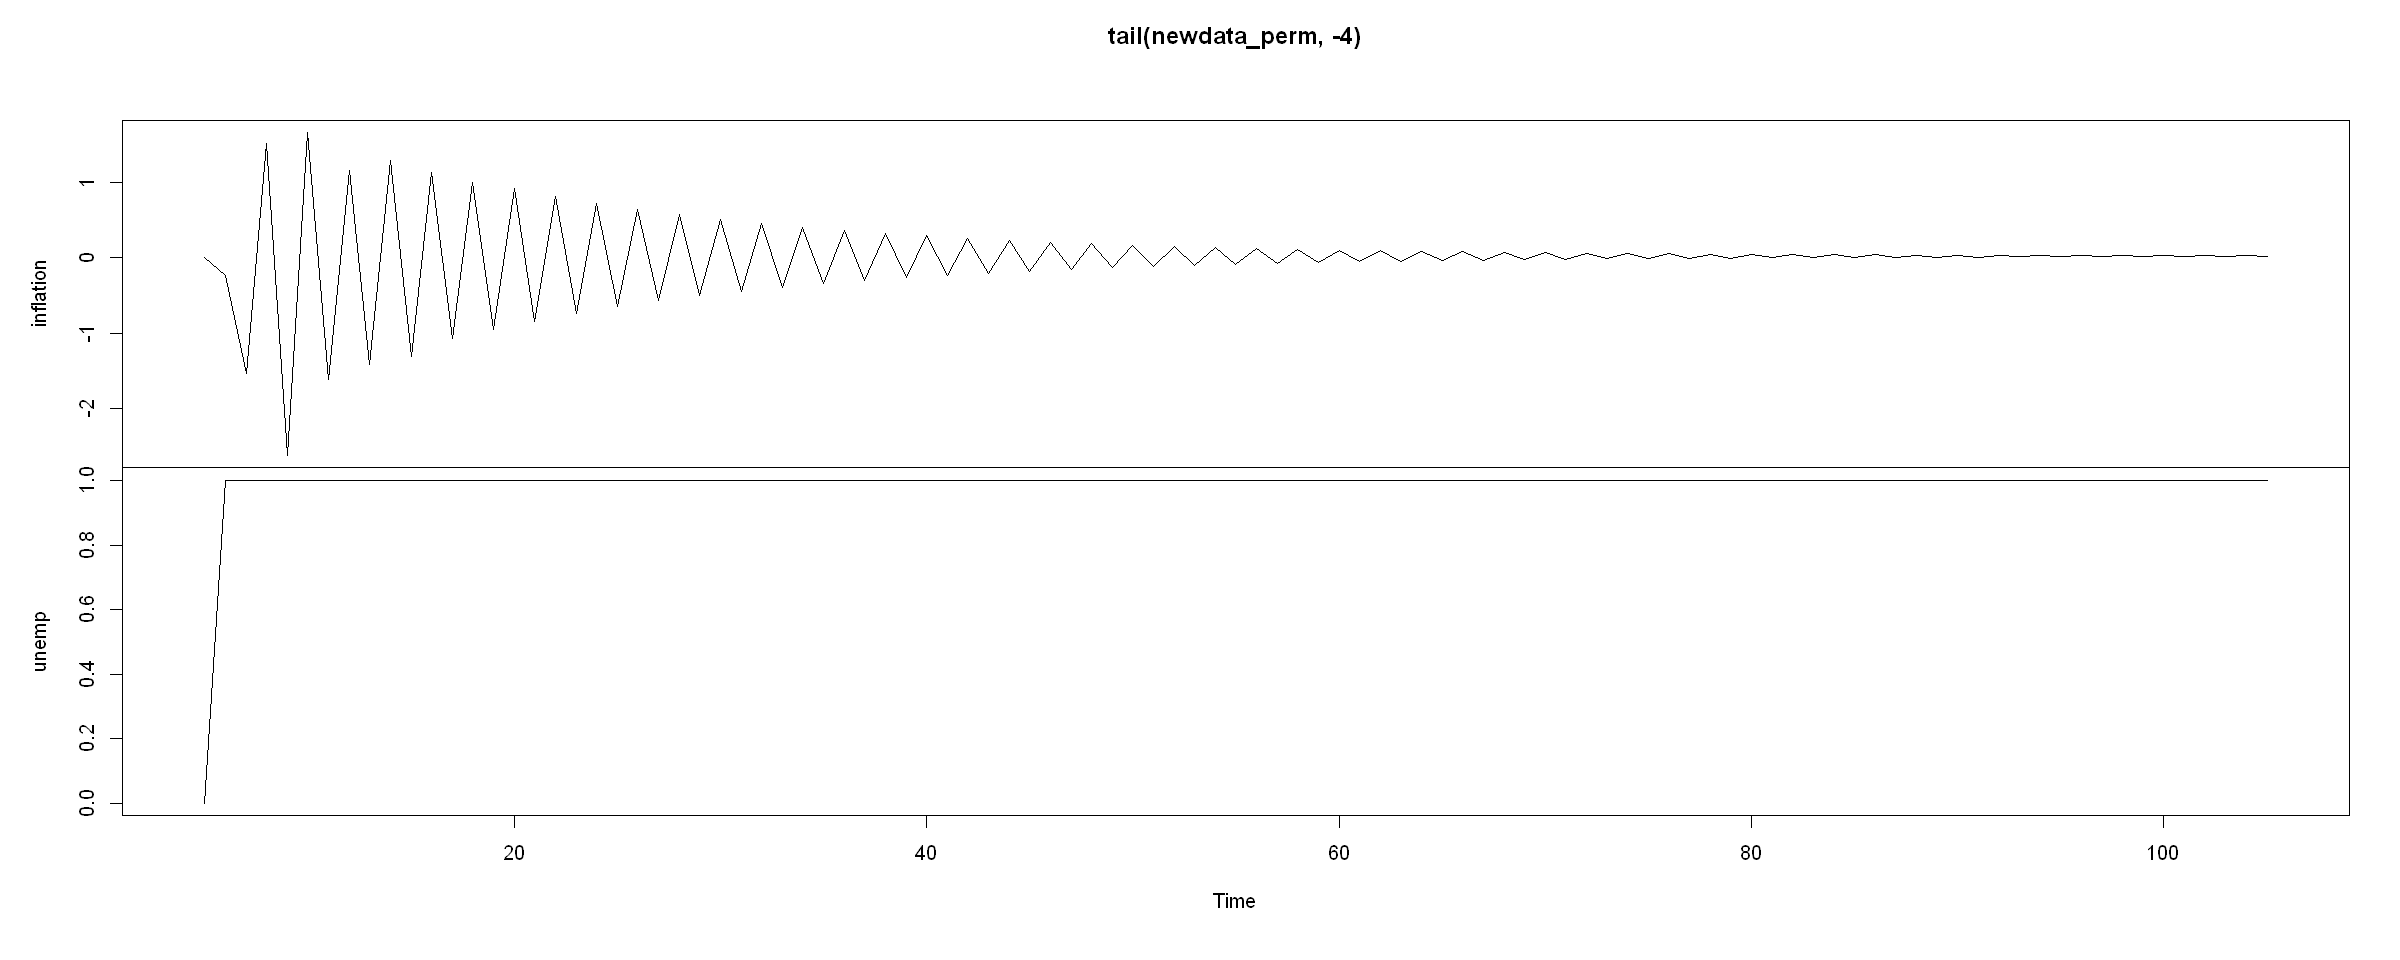

In [96]:
plot.ts(tail(newdata_perm, -4))